# Postprocessing of ISS data:

This notebook guides you through the different steps that will eventually allow you to analyse ISS data at the single cell level.

To complete this tutorial you should have completed the previous steps, and you will need the following ingredients.

1. Your decoded data, in the standard decoded format as we have generated from the `ISS_decoding` notebook.
2. A DAPI stitched image of your tissue. We typically use the `Round_0...` stitched image in the `/preprocessing/stitched/` subfolder. Make sure you choose the appropriate channel for DAPI.
3. time, patience, and some knowledge of single-cell analysis.


The analysis is based on Scanpy (documentation in  https://scanpy.readthedocs.io/en/stable/index.html) and Squidpy (documentation in https://squidpy.readthedocs.io/en/stable/)


## Import packages
We import the necessary packages. `ISS_postprocessing` includes some modules requiring a functional and properly installed CUDA-compatible GPU. They will work but they will be considerably slower on CPU.

In [1]:
import ISS_postprocessing
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
DIPlib -- a quantitative image analysis library
Version 3.2.0 (Feb  8 2022)
For more information see https://diplib.org


In the following code block you need to add the paths to each one of the samples you want to post-process. Note that you can post-process multiple samples in one go, but they will all be analysed in the same way. This is normally OK, but there might be exceptions in which you want to treat your samples differently for some reason.



In [231]:
samples = ['/media/marco/Meola/GECKO_Ago22_CARE/_R 1 Corrected/',
        '/media/marco/Meola/GECKO_Ago22_CARE/_R 2 Corrected/',
           '/media/marco/Meola/GECKO_Ago22_CARE/_R 2 Corrected/',
           '/media/marco/Meola/GECKO_Ago22_CARE/_R 3 Corrected/',
           '/media/marco/Meola/GECKO_Ago22_CARE/_R 4 Corrected/',
           '/media/marco/Meola/GECKO_Ago22_CARE/_R 5 Corrected/',
           '/media/marco/Meola/GECKO_Ago22_CARE/_R 6 Corrected/',
           '/media/marco/Meola/GECKO_Ago22_CARE/_R 7 Corrected/',
           '/media/marco/Meola/GECKO_Ago22_CARE/_R 8 Corrected/',
           '/media/marco/Meola/GECKO_Ago22_CARE/_R 9 Corrected/'
          ]

## Cell segmentation

In this step we will first build a **segmentation mask** based on the DAPI signal, so the script will search for a DAPI file in the subfolders within each sample folder. The file that is typically loaded is at `/sample/preprocessing/stitched/Round0_4.tif`, so it's the stitched DAPI image corresponding to the first imaging cycle. Please change the channel number if DAPI is not in the indicated channel.

The `ISS_postprocessing.segmentation.stardist_segmentation` implements several method for cell segmentation, based on `stardist` or `cellpose`. Custom segmentation using other methods can also be performed, but need to be done externally to this notebook.

In this specific tutorial, `stardist` is implemented. Have a look at the functions in `ISS_postprocessing.segmentation` for alternative strategies.

In the following function the following parameters can be speficied:

`image_path`: the path to the DAPI image as a string. In this example case it's automatically built within the loop

`output_path` = where the image will be saved 

`model_name` = '2D_versatile_fluo', this is one of the pre-trained model from `stardist`. Can be changed to a custom model or other pre-trained models. Please consult the `stardist` documentation

`expand_cells` = determines whether, post-segmentation, each cell needs to be expanded. Default==True. Expansion allows to capture perinuclear/extranuclear signal and it is advisable (although with caution, read below)

`n_tiles` = (x,y) allows to tile the image in smaller blocks for faster processing. Default=(4,4) 

`expanded_distance` = 20 determines how much each nucleus is expanded (in pixels)

In [7]:
for sample in samples: 
    ISS_postprocessing.segmentation.stardist_segmentation(image_path = sample + '/preprocessing/stitched/Round0_4.tif', 
                                                      output_path = sample, 
                                                      model_name = '2D_versatile_fluo',
                                                      expand_cells = True, 
                                                      n_tiles = (4,4), 
                                                      expanded_distance = 20,)

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
(9687, 13483)
normalize image
predict instance


2023-09-18 10:26:58.848007: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800
2023-09-18 10:27:04.700539: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 36ms/step


  0%|                                                                                                                                                                              | 0/16 [00:00<?, ?it/s]

1/1 [==============================] - 5s 5s/step


  6%|██████████▍                                                                                                                                                           | 1/16 [00:06<01:30,  6.03s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████████████████▊                                                                                                                                                 | 2/16 [00:06<00:40,  2.87s/it]

1/1 [==============================] - 0s 51ms/step


 19%|███████████████████████████████▏                                                                                                                                      | 3/16 [00:07<00:24,  1.87s/it]

1/1 [==============================] - 0s 54ms/step


 25%|█████████████████████████████████████████▌                                                                                                                            | 4/16 [00:08<00:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|███████████████████████████████████████████████████▉                                                                                                                  | 5/16 [00:08<00:12,  1.16s/it]

1/1 [==============================] - 0s 51ms/step


 38%|██████████████████████████████████████████████████████████████▎                                                                                                       | 6/16 [00:09<00:09,  1.01it/s]

1/1 [==============================] - 0s 54ms/step


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 7/16 [00:10<00:08,  1.11it/s]

1/1 [==============================] - 0s 52ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 8/16 [00:10<00:06,  1.20it/s]

1/1 [==============================] - 0s 54ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 9/16 [00:11<00:05,  1.27it/s]

1/1 [==============================] - 0s 54ms/step


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 10/16 [00:12<00:04,  1.31it/s]

1/1 [==============================] - 0s 55ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 11/16 [00:12<00:03,  1.34it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 12/16 [00:13<00:02,  1.39it/s]

1/1 [==============================] - 0s 50ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 13/16 [00:14<00:02,  1.41it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 14/16 [00:14<00:01,  1.43it/s]

1/1 [==============================] - 0s 56ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 15/16 [00:15<00:00,  1.45it/s]

1/1 [==============================] - 0s 52ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


label image
expand image
save output
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
(9682, 13485)
normalize image
predict instance
1/1 [==============================] - 0s 22ms/step


  0%|                                                                                                                                                                              | 0/16 [00:00<?, ?it/s]

1/1 [==============================] - 0s 228ms/step


  6%|██████████▍                                                                                                                                                           | 1/16 [00:00<00:13,  1.08it/s]

1/1 [==============================] - 0s 52ms/step


 12%|████████████████████▊                                                                                                                                                 | 2/16 [00:01<00:10,  1.32it/s]

1/1 [==============================] - 0s 54ms/step


 19%|███████████████████████████████▏                                                                                                                                      | 3/16 [00:02<00:09,  1.42it/s]

1/1 [==============================] - 0s 51ms/step


 25%|█████████████████████████████████████████▌                                                                                                                            | 4/16 [00:02<00:08,  1.46it/s]

1/1 [==============================] - 0s 54ms/step


 31%|███████████████████████████████████████████████████▉                                                                                                                  | 5/16 [00:03<00:07,  1.47it/s]

1/1 [==============================] - 0s 73ms/step


 38%|██████████████████████████████████████████████████████████████▎                                                                                                       | 6/16 [00:04<00:06,  1.45it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 7/16 [00:04<00:06,  1.45it/s]

1/1 [==============================] - 0s 49ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 8/16 [00:05<00:05,  1.45it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 9/16 [00:06<00:04,  1.45it/s]

1/1 [==============================] - 0s 50ms/step


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 10/16 [00:07<00:04,  1.45it/s]

1/1 [==============================] - 0s 49ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 11/16 [00:07<00:03,  1.45it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 12/16 [00:08<00:02,  1.47it/s]

1/1 [==============================] - 0s 55ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 13/16 [00:09<00:02,  1.46it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 14/16 [00:09<00:01,  1.47it/s]

1/1 [==============================] - 0s 51ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 15/16 [00:10<00:00,  1.48it/s]

1/1 [==============================] - 0s 54ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]


label image
expand image
save output
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
(9682, 13485)
normalize image
predict instance
1/1 [==============================] - 0s 22ms/step


  0%|                                                                                                                                                                              | 0/16 [00:00<?, ?it/s]

1/1 [==============================] - 0s 214ms/step


  6%|██████████▍                                                                                                                                                           | 1/16 [00:00<00:13,  1.08it/s]

1/1 [==============================] - 0s 49ms/step


 12%|████████████████████▊                                                                                                                                                 | 2/16 [00:01<00:10,  1.32it/s]

1/1 [==============================] - 0s 57ms/step


 19%|███████████████████████████████▏                                                                                                                                      | 3/16 [00:02<00:09,  1.39it/s]

1/1 [==============================] - 0s 55ms/step


 25%|█████████████████████████████████████████▌                                                                                                                            | 4/16 [00:02<00:08,  1.43it/s]

1/1 [==============================] - 0s 52ms/step


 31%|███████████████████████████████████████████████████▉                                                                                                                  | 5/16 [00:03<00:07,  1.44it/s]

1/1 [==============================] - 0s 54ms/step


 38%|██████████████████████████████████████████████████████████████▎                                                                                                       | 6/16 [00:04<00:06,  1.46it/s]

1/1 [==============================] - 0s 51ms/step


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 7/16 [00:04<00:06,  1.46it/s]

1/1 [==============================] - 0s 52ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 8/16 [00:05<00:05,  1.47it/s]

1/1 [==============================] - 0s 59ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 9/16 [00:06<00:04,  1.48it/s]

1/1 [==============================] - 0s 52ms/step


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 10/16 [00:06<00:04,  1.48it/s]

1/1 [==============================] - 0s 49ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 11/16 [00:07<00:03,  1.49it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 12/16 [00:08<00:02,  1.51it/s]

1/1 [==============================] - 0s 47ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 13/16 [00:08<00:01,  1.51it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 14/16 [00:09<00:01,  1.52it/s]

1/1 [==============================] - 0s 56ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 15/16 [00:10<00:00,  1.53it/s]

1/1 [==============================] - 0s 56ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


label image
expand image
save output
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
(9685, 13486)
normalize image
predict instance
1/1 [==============================] - 0s 23ms/step


  0%|                                                                                                                                                                              | 0/16 [00:00<?, ?it/s]

1/1 [==============================] - 0s 230ms/step


  6%|██████████▍                                                                                                                                                           | 1/16 [00:00<00:14,  1.07it/s]

1/1 [==============================] - 0s 53ms/step


 12%|████████████████████▊                                                                                                                                                 | 2/16 [00:01<00:10,  1.32it/s]

1/1 [==============================] - 0s 55ms/step


 19%|███████████████████████████████▏                                                                                                                                      | 3/16 [00:02<00:09,  1.41it/s]

1/1 [==============================] - 0s 59ms/step


 25%|█████████████████████████████████████████▌                                                                                                                            | 4/16 [00:02<00:08,  1.44it/s]

1/1 [==============================] - 0s 51ms/step


 31%|███████████████████████████████████████████████████▉                                                                                                                  | 5/16 [00:03<00:07,  1.45it/s]

1/1 [==============================] - 0s 55ms/step


 38%|██████████████████████████████████████████████████████████████▎                                                                                                       | 6/16 [00:04<00:06,  1.47it/s]

1/1 [==============================] - 0s 51ms/step


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 7/16 [00:04<00:06,  1.48it/s]

1/1 [==============================] - 0s 51ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 8/16 [00:05<00:05,  1.49it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 9/16 [00:06<00:04,  1.51it/s]

1/1 [==============================] - 0s 56ms/step


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 10/16 [00:06<00:03,  1.50it/s]

1/1 [==============================] - 0s 59ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 11/16 [00:07<00:03,  1.51it/s]

1/1 [==============================] - 0s 54ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 12/16 [00:08<00:02,  1.53it/s]

1/1 [==============================] - 0s 59ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 13/16 [00:08<00:01,  1.53it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 14/16 [00:09<00:01,  1.53it/s]

1/1 [==============================] - 0s 52ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 15/16 [00:10<00:00,  1.54it/s]

1/1 [==============================] - 0s 54ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.49it/s]


label image
expand image
save output
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
(9677, 11583)
normalize image
predict instance
1/1 [==============================] - 0s 20ms/step


  0%|                                                                                                                                                                              | 0/16 [00:00<?, ?it/s]

1/1 [==============================] - 5s 5s/step


  6%|██████████▍                                                                                                                                                           | 1/16 [00:05<01:19,  5.28s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████████████████▊                                                                                                                                                 | 2/16 [00:05<00:35,  2.50s/it]

1/1 [==============================] - 0s 55ms/step


 19%|███████████████████████████████▏                                                                                                                                      | 3/16 [00:06<00:21,  1.62s/it]

1/1 [==============================] - 0s 46ms/step


 25%|█████████████████████████████████████████▌                                                                                                                            | 4/16 [00:06<00:14,  1.21s/it]

1/1 [==============================] - 0s 50ms/step


 31%|███████████████████████████████████████████████████▉                                                                                                                  | 5/16 [00:07<00:10,  1.01it/s]

1/1 [==============================] - 0s 34ms/step


 38%|██████████████████████████████████████████████████████████████▎                                                                                                       | 6/16 [00:08<00:08,  1.19it/s]

1/1 [==============================] - 0s 52ms/step


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 7/16 [00:08<00:06,  1.32it/s]

1/1 [==============================] - 0s 47ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 8/16 [00:09<00:05,  1.43it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 9/16 [00:09<00:04,  1.51it/s]

1/1 [==============================] - 0s 50ms/step


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 10/16 [00:10<00:03,  1.57it/s]

1/1 [==============================] - 0s 45ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 11/16 [00:11<00:03,  1.62it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 12/16 [00:11<00:02,  1.67it/s]

1/1 [==============================] - 0s 50ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 13/16 [00:12<00:01,  1.69it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 14/16 [00:12<00:01,  1.72it/s]

1/1 [==============================] - 0s 51ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 15/16 [00:13<00:00,  1.75it/s]

1/1 [==============================] - 0s 65ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


label image
expand image
save output
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
(9687, 11586)
normalize image
predict instance
1/1 [==============================] - 0s 23ms/step


  0%|                                                                                                                                                                              | 0/16 [00:00<?, ?it/s]

1/1 [==============================] - 5s 5s/step


  6%|██████████▍                                                                                                                                                           | 1/16 [00:05<01:19,  5.32s/it]

1/1 [==============================] - 0s 51ms/step


 12%|████████████████████▊                                                                                                                                                 | 2/16 [00:05<00:35,  2.52s/it]

1/1 [==============================] - 0s 37ms/step


 19%|███████████████████████████████▏                                                                                                                                      | 3/16 [00:06<00:21,  1.62s/it]

1/1 [==============================] - 0s 41ms/step


 25%|█████████████████████████████████████████▌                                                                                                                            | 4/16 [00:06<00:14,  1.20s/it]

1/1 [==============================] - 0s 50ms/step


 31%|███████████████████████████████████████████████████▉                                                                                                                  | 5/16 [00:07<00:10,  1.02it/s]

1/1 [==============================] - 0s 39ms/step


 38%|██████████████████████████████████████████████████████████████▎                                                                                                       | 6/16 [00:08<00:08,  1.19it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 7/16 [00:08<00:06,  1.31it/s]

1/1 [==============================] - 0s 39ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 8/16 [00:09<00:05,  1.43it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 9/16 [00:09<00:04,  1.52it/s]

1/1 [==============================] - 0s 39ms/step


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 10/16 [00:10<00:03,  1.57it/s]

1/1 [==============================] - 0s 38ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 11/16 [00:11<00:03,  1.62it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 12/16 [00:11<00:02,  1.67it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 13/16 [00:12<00:01,  1.69it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 14/16 [00:12<00:01,  1.71it/s]

1/1 [==============================] - 0s 39ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 15/16 [00:13<00:00,  1.73it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]


label image
expand image
save output
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
(9686, 11594)
normalize image
predict instance
1/1 [==============================] - 0s 21ms/step


  0%|                                                                                                                                                                              | 0/16 [00:00<?, ?it/s]

1/1 [==============================] - 0s 223ms/step


  6%|██████████▍                                                                                                                                                           | 1/16 [00:00<00:12,  1.25it/s]

1/1 [==============================] - 0s 37ms/step


 12%|████████████████████▊                                                                                                                                                 | 2/16 [00:01<00:09,  1.51it/s]

1/1 [==============================] - 0s 34ms/step


 19%|███████████████████████████████▏                                                                                                                                      | 3/16 [00:01<00:08,  1.61it/s]

1/1 [==============================] - 0s 40ms/step


 25%|█████████████████████████████████████████▌                                                                                                                            | 4/16 [00:02<00:07,  1.66it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███████████████████████████████████████████████████▉                                                                                                                  | 5/16 [00:03<00:06,  1.66it/s]

1/1 [==============================] - 0s 38ms/step


 38%|██████████████████████████████████████████████████████████████▎                                                                                                       | 6/16 [00:03<00:05,  1.68it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 7/16 [00:04<00:05,  1.68it/s]

1/1 [==============================] - 0s 40ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 8/16 [00:04<00:04,  1.69it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 9/16 [00:05<00:04,  1.69it/s]

1/1 [==============================] - 0s 40ms/step


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 10/16 [00:06<00:03,  1.68it/s]

1/1 [==============================] - 0s 52ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 11/16 [00:06<00:02,  1.67it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 12/16 [00:07<00:02,  1.70it/s]

1/1 [==============================] - 0s 38ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 13/16 [00:07<00:01,  1.71it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 14/16 [00:08<00:01,  1.72it/s]

1/1 [==============================] - 0s 36ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 15/16 [00:08<00:00,  1.72it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.68it/s]


label image
expand image
save output
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
(9684, 11575)
normalize image
predict instance
1/1 [==============================] - 0s 22ms/step


  0%|                                                                                                                                                                              | 0/16 [00:00<?, ?it/s]

1/1 [==============================] - 0s 214ms/step


  6%|██████████▍                                                                                                                                                           | 1/16 [00:00<00:12,  1.21it/s]

1/1 [==============================] - 0s 49ms/step


 12%|████████████████████▊                                                                                                                                                 | 2/16 [00:01<00:09,  1.48it/s]

1/1 [==============================] - 0s 37ms/step


 19%|███████████████████████████████▏                                                                                                                                      | 3/16 [00:01<00:08,  1.58it/s]

1/1 [==============================] - 0s 50ms/step


 25%|█████████████████████████████████████████▌                                                                                                                            | 4/16 [00:02<00:07,  1.65it/s]

1/1 [==============================] - 0s 51ms/step


 31%|███████████████████████████████████████████████████▉                                                                                                                  | 5/16 [00:03<00:06,  1.63it/s]

1/1 [==============================] - 0s 51ms/step


 38%|██████████████████████████████████████████████████████████████▎                                                                                                       | 6/16 [00:03<00:06,  1.65it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 7/16 [00:04<00:05,  1.67it/s]

1/1 [==============================] - 0s 44ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 8/16 [00:04<00:04,  1.69it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 9/16 [00:05<00:04,  1.71it/s]

1/1 [==============================] - 0s 37ms/step


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 10/16 [00:06<00:03,  1.71it/s]

1/1 [==============================] - 0s 39ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 11/16 [00:06<00:02,  1.72it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 12/16 [00:07<00:02,  1.74it/s]

1/1 [==============================] - 0s 39ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 13/16 [00:07<00:01,  1.75it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 14/16 [00:08<00:01,  1.76it/s]

1/1 [==============================] - 0s 54ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 15/16 [00:08<00:00,  1.75it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.69it/s]


label image
expand image
save output
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
(7783, 11589)
normalize image
predict instance
1/1 [==============================] - 0s 22ms/step


  0%|                                                                                                                                                                              | 0/16 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  6%|██████████▍                                                                                                                                                           | 1/16 [00:03<00:56,  3.76s/it]

1/1 [==============================] - 0s 36ms/step


 12%|████████████████████▊                                                                                                                                                 | 2/16 [00:04<00:25,  1.82s/it]

1/1 [==============================] - 0s 47ms/step


 19%|███████████████████████████████▏                                                                                                                                      | 3/16 [00:04<00:15,  1.22s/it]

1/1 [==============================] - 0s 35ms/step


 25%|█████████████████████████████████████████▌                                                                                                                            | 4/16 [00:05<00:11,  1.08it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███████████████████████████████████████████████████▉                                                                                                                  | 5/16 [00:05<00:08,  1.29it/s]

1/1 [==============================] - 0s 34ms/step


 38%|██████████████████████████████████████████████████████████████▎                                                                                                       | 6/16 [00:06<00:06,  1.49it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 7/16 [00:06<00:05,  1.65it/s]

1/1 [==============================] - 0s 46ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 8/16 [00:07<00:04,  1.75it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 9/16 [00:07<00:03,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 10/16 [00:08<00:03,  1.90it/s]

1/1 [==============================] - 0s 43ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 11/16 [00:08<00:02,  1.94it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 12/16 [00:09<00:02,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 13/16 [00:09<00:01,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 14/16 [00:10<00:00,  2.04it/s]

1/1 [==============================] - 0s 37ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 15/16 [00:10<00:00,  2.06it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.46it/s]


label image
expand image
save output
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
(7784, 11590)
normalize image
predict instance
1/1 [==============================] - 0s 23ms/step


  0%|                                                                                                                                                                              | 0/16 [00:00<?, ?it/s]

1/1 [==============================] - 0s 193ms/step


  6%|██████████▍                                                                                                                                                           | 1/16 [00:00<00:10,  1.44it/s]

1/1 [==============================] - 0s 37ms/step


 12%|████████████████████▊                                                                                                                                                 | 2/16 [00:01<00:07,  1.77it/s]

1/1 [==============================] - 0s 46ms/step


 19%|███████████████████████████████▏                                                                                                                                      | 3/16 [00:01<00:06,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


 25%|█████████████████████████████████████████▌                                                                                                                            | 4/16 [00:02<00:06,  2.00it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███████████████████████████████████████████████████▉                                                                                                                  | 5/16 [00:02<00:05,  1.99it/s]

1/1 [==============================] - 0s 42ms/step


 38%|██████████████████████████████████████████████████████████████▎                                                                                                       | 6/16 [00:03<00:04,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 7/16 [00:03<00:04,  2.05it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 8/16 [00:04<00:03,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 9/16 [00:04<00:03,  2.06it/s]

1/1 [==============================] - 0s 48ms/step


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 10/16 [00:05<00:02,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 11/16 [00:05<00:02,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 12/16 [00:05<00:01,  2.07it/s]

1/1 [==============================] - 0s 38ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 13/16 [00:06<00:01,  2.08it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 14/16 [00:06<00:00,  2.08it/s]

1/1 [==============================] - 0s 47ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 15/16 [00:07<00:00,  2.08it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.03it/s]


label image
expand image
save output


## Integrate the ISS data on the segmentation mask and create AnnData objects

This step takes your decoded spots, and based on the position of each spot assigns it to a specific cell. Then it implements some filtering and conversion steps, and save the object as an `Annotated_Data`.

Let's look at the variables:


`spots_file` = the location of the decoded spots .csv file 

`segmentation_mask`= the location to the npz expanded segmentation mask

`output_file` = the location where the hda5 AnnData file will be saved for each sample

`filter_data`= A boolean specifying whether you want to filter the ISS data on a quality criterion (default=True) 

`metric` = defines **which parameter you want to use for filtering the ISS data** I suggest using the `quality_minimum`

`write_h5ad` = A boolean specifying if the AnnData needs to be saved as h5ad (default==True)

`value`= this is a value specifying **which value is used for filterin** (if quality_minimum was chosen as metric, I'd suggest 0.4-0.5)

`convert_coords` = This converts the coordinates from pixel to nm, and whether it's needed or not will depend on your settings in the `ISS_decoding` notebook. default is True 

`conversion_factor` = this specifies the XY pixel size.

These last 2 steps are to ensure your decoded data actually match the DAPI image. If you don't do these steps right, your segmentation will be completely off and your data will not make any sense.

In [232]:
for sample_path in samples:  
        ad = ISS_postprocessing.annotated_objects.create_anndata_obj(spots_file = sample_path+'/decoded.csv', 
            segmentation_mask = sample_path+'stardist_segmentation_expanded.npz',#'cell_segmentation/cellpose_segmentation_expanded_2.npz' 
            output_file = sample_path+'/anndata_stardist.h5ad',
            filter_data=True, 
            metric = 'quality_minimum', 
            write_h5ad = True,
            value=  0.4,
            convert_coords = True, 
            conversion_factor = 0.1625)

reading spots file
load coo file


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([11, 15], dtype='int64'), …
AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([11, 15], dtype='int64'), …


assign spots to cells
write h5ad
reading spots file
load coo file


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([2, 8], dtype='int64'), …
AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([2, 8], dtype='int64'), …


assign spots to cells
write h5ad
reading spots file
load coo file


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([2, 8], dtype='int64'), …
AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([2, 8], dtype='int64'), …


assign spots to cells
write h5ad
reading spots file
load coo file


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([16, 25], dtype='int64'), …
AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([16, 25], dtype='int64'), …


assign spots to cells
write h5ad
reading spots file
load coo file


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([4, 10], dtype='int64'), …
AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([4, 10], dtype='int64'), …


assign spots to cells
write h5ad
reading spots file
load coo file


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([3, 4], dtype='int64'), …
AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([3, 4], dtype='int64'), …


assign spots to cells
write h5ad
reading spots file
load coo file


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([2, 3], dtype='int64'), …
AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([2, 3], dtype='int64'), …


assign spots to cells
write h5ad
reading spots file
load coo file


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …
AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


assign spots to cells
write h5ad
reading spots file
load coo file


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …
AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


assign spots to cells
write h5ad
reading spots file
load coo file


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …
AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


assign spots to cells
write h5ad


## Concatenation of multiple AnnData objects for joint analysis.

When working with multiple samples, you might want to concatenate all the respective  AnnData objects into one single file. This allows you to treat all of your sections as a single dataset. The code block down here formats the data in a way that `.obs['sample_id']` will contain data about a specific section.

In [235]:
ad =  ISS_postprocessing.annotated_objects.concat_anndata(sample_anndata_list = samples, 
                  anndata_name = 'anndata_stardist.h5ad'
                  )
ad.obs['sample_id'] = ad.obs['sample_id'].str.split('/', expand = True)[5] 

/media/marco/Meola/GECKO_Ago22_CARE/_R 1 Corrected/anndata_stardist.h5ad
/media/marco/Meola/GECKO_Ago22_CARE/_R 2 Corrected/anndata_stardist.h5ad
/media/marco/Meola/GECKO_Ago22_CARE/_R 2 Corrected/anndata_stardist.h5ad
/media/marco/Meola/GECKO_Ago22_CARE/_R 3 Corrected/anndata_stardist.h5ad
/media/marco/Meola/GECKO_Ago22_CARE/_R 4 Corrected/anndata_stardist.h5ad
/media/marco/Meola/GECKO_Ago22_CARE/_R 5 Corrected/anndata_stardist.h5ad
/media/marco/Meola/GECKO_Ago22_CARE/_R 6 Corrected/anndata_stardist.h5ad
/media/marco/Meola/GECKO_Ago22_CARE/_R 7 Corrected/anndata_stardist.h5ad
/media/marco/Meola/GECKO_Ago22_CARE/_R 8 Corrected/anndata_stardist.h5ad
/media/marco/Meola/GECKO_Ago22_CARE/_R 9 Corrected/anndata_stardist.h5ad


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In the following step some useful metrics about the experiment are calculated. 

In [239]:
sc.pp.calculate_qc_metrics(ad, percent_top=None, log1p=False, inplace=True)

The following block of code allows us to visualize the distribution of `total_counts` in the cells. This will allow you to determine a few things, and understand your data a bit.

1. cells with a very low `total_counts` will be useless for clustering (especially 0s) so you might want to filter them out

2. cells with unusually high `total_counts` are often arising because of segmentation artifacts. If most of the cells have around 30 counts, cells with 100s of counts are somewhat suspicious.

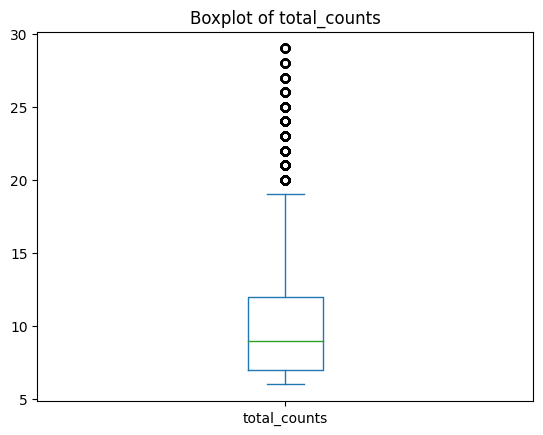

In [261]:
import matplotlib.pyplot as plt
ad.obs['total_counts'].plot(kind='box')
plt.title('Boxplot of total_counts')
plt.show()

Similar considerations apply also to this other metrics, the `n_genes_by_counts` measure. This tells us **how many unique genes are detected in each cell**. Cells that express only 1 or very few genes are usually suspicious, and we might want to filter them out.

**All of these considerations of course will depend on the number of genes you probe for in the ISS panel and also the efficiency of detection, etc...**
The boxplots above are meant to visually inspect these metrics and aid in making a decision about meaningful filtering threshold in the next step.

In [ ]:
import matplotlib.pyplot as plt
ad.obs['n_genes_by_counts'].plot(kind='box')
plt.title('Boxplot of n_genes_by_counts')
plt.show()

## Set filtering thresholds and discard uninformative cells

By modifying the line below we get to choose values to filter the cells based on the metric discussed before:

In the example here, we'll keep only the cells with more than 5 spots, coming from at least 2 different genes. 

In [256]:
keep = (ad.obs['total_counts'] > 5) & (ad.obs['n_genes_by_counts'] > 2 )
print(sum(keep))

54424


In [ ]:
ad = ad[keep,:]

## Normalization and transformation

Now your data is stored in the `ad` object as raw data. 

We now copy the raw data into `ad.raw`, and store it for later use if needed. 

To the data in `ad` we apply normalization and log-transformation to minimize the effect of outliers. 

We also scale the data to give the same importance to all genes in clustering.

There's a lot of debate about which normalization method one should use for ISS data, and whether one would need to scale at all, so take all of this with a grain of salt.



In [264]:
ad.layers["raw"] = ad.X.copy()
sc.experimental.pp.normalize_pearson_residuals(ad)
normalized_exp = np.array(ad.X)
normalized_exp[normalized_exp< 0] = 0
ad.X =  normalized_exp
sc.pp.log1p(ad)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Here we run a standard PCA and proceed with the analysis as in scRNAseq workflows.

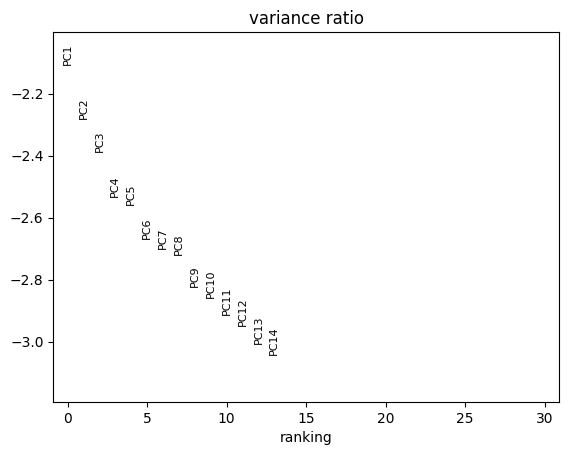

In [265]:
sc.tl.pca(ad, svd_solver='arpack')
plt.rcParams['figure.facecolor'] = 'white'
sc.pl.pca_variance_ratio(ad, log=True)

By changing the `n_neighbors`, `n_pcs` and `min_dist` in the code below, you can change the clustering properties. Refer to the `scanpy` manual for more information.

In [ ]:
sc.pp.neighbors(ad, n_neighbors=20, n_pcs=40)
sc.tl.umap(ad,min_dist=0.005) #0.005

Here we choose 2 resolutions to visualize the cells on the UMAP and plot the results.

In [ ]:
for i in [0.3, 0.4]:
    if "norm_leiden_"+str(i) in ad.obs.columns:
        plt.rcdefaults()
        with plt.rc_context({'figure.figsize': (15, 10)}):
            sc.pl.umap(ad, color = ("norm_leiden_"+str(i)),s=5,add_outline=False,legend_loc='on data',legend_fontsize=20,legend_fontoutline=2,alpha = 1)
    else: 
        print('clustering @ resolution ' + str(i))
        sc.tl.leiden(ad, resolution =i, key_added = ("norm_leiden_"+str(i)))
        plt.rcdefaults()
        with plt.rc_context({'figure.figsize': (15, 10)}):
            sc.pl.umap(ad, color = ("norm_leiden_"+str(i)),s=5,add_outline=False,legend_loc='on data',legend_fontsize=20,legend_fontoutline=2)

This block of code extracts the positions of the cells for plotting.

In [208]:
spatial = np.array(ad.obs[['x','y']].astype('<f8'))
ad.obsm['spatial'] = spatial

ad.obsm['xy_loc'] = spatial

And finally here we can plot the **spatial distribution of the different clusters** in one go.

_R 1 Corrected


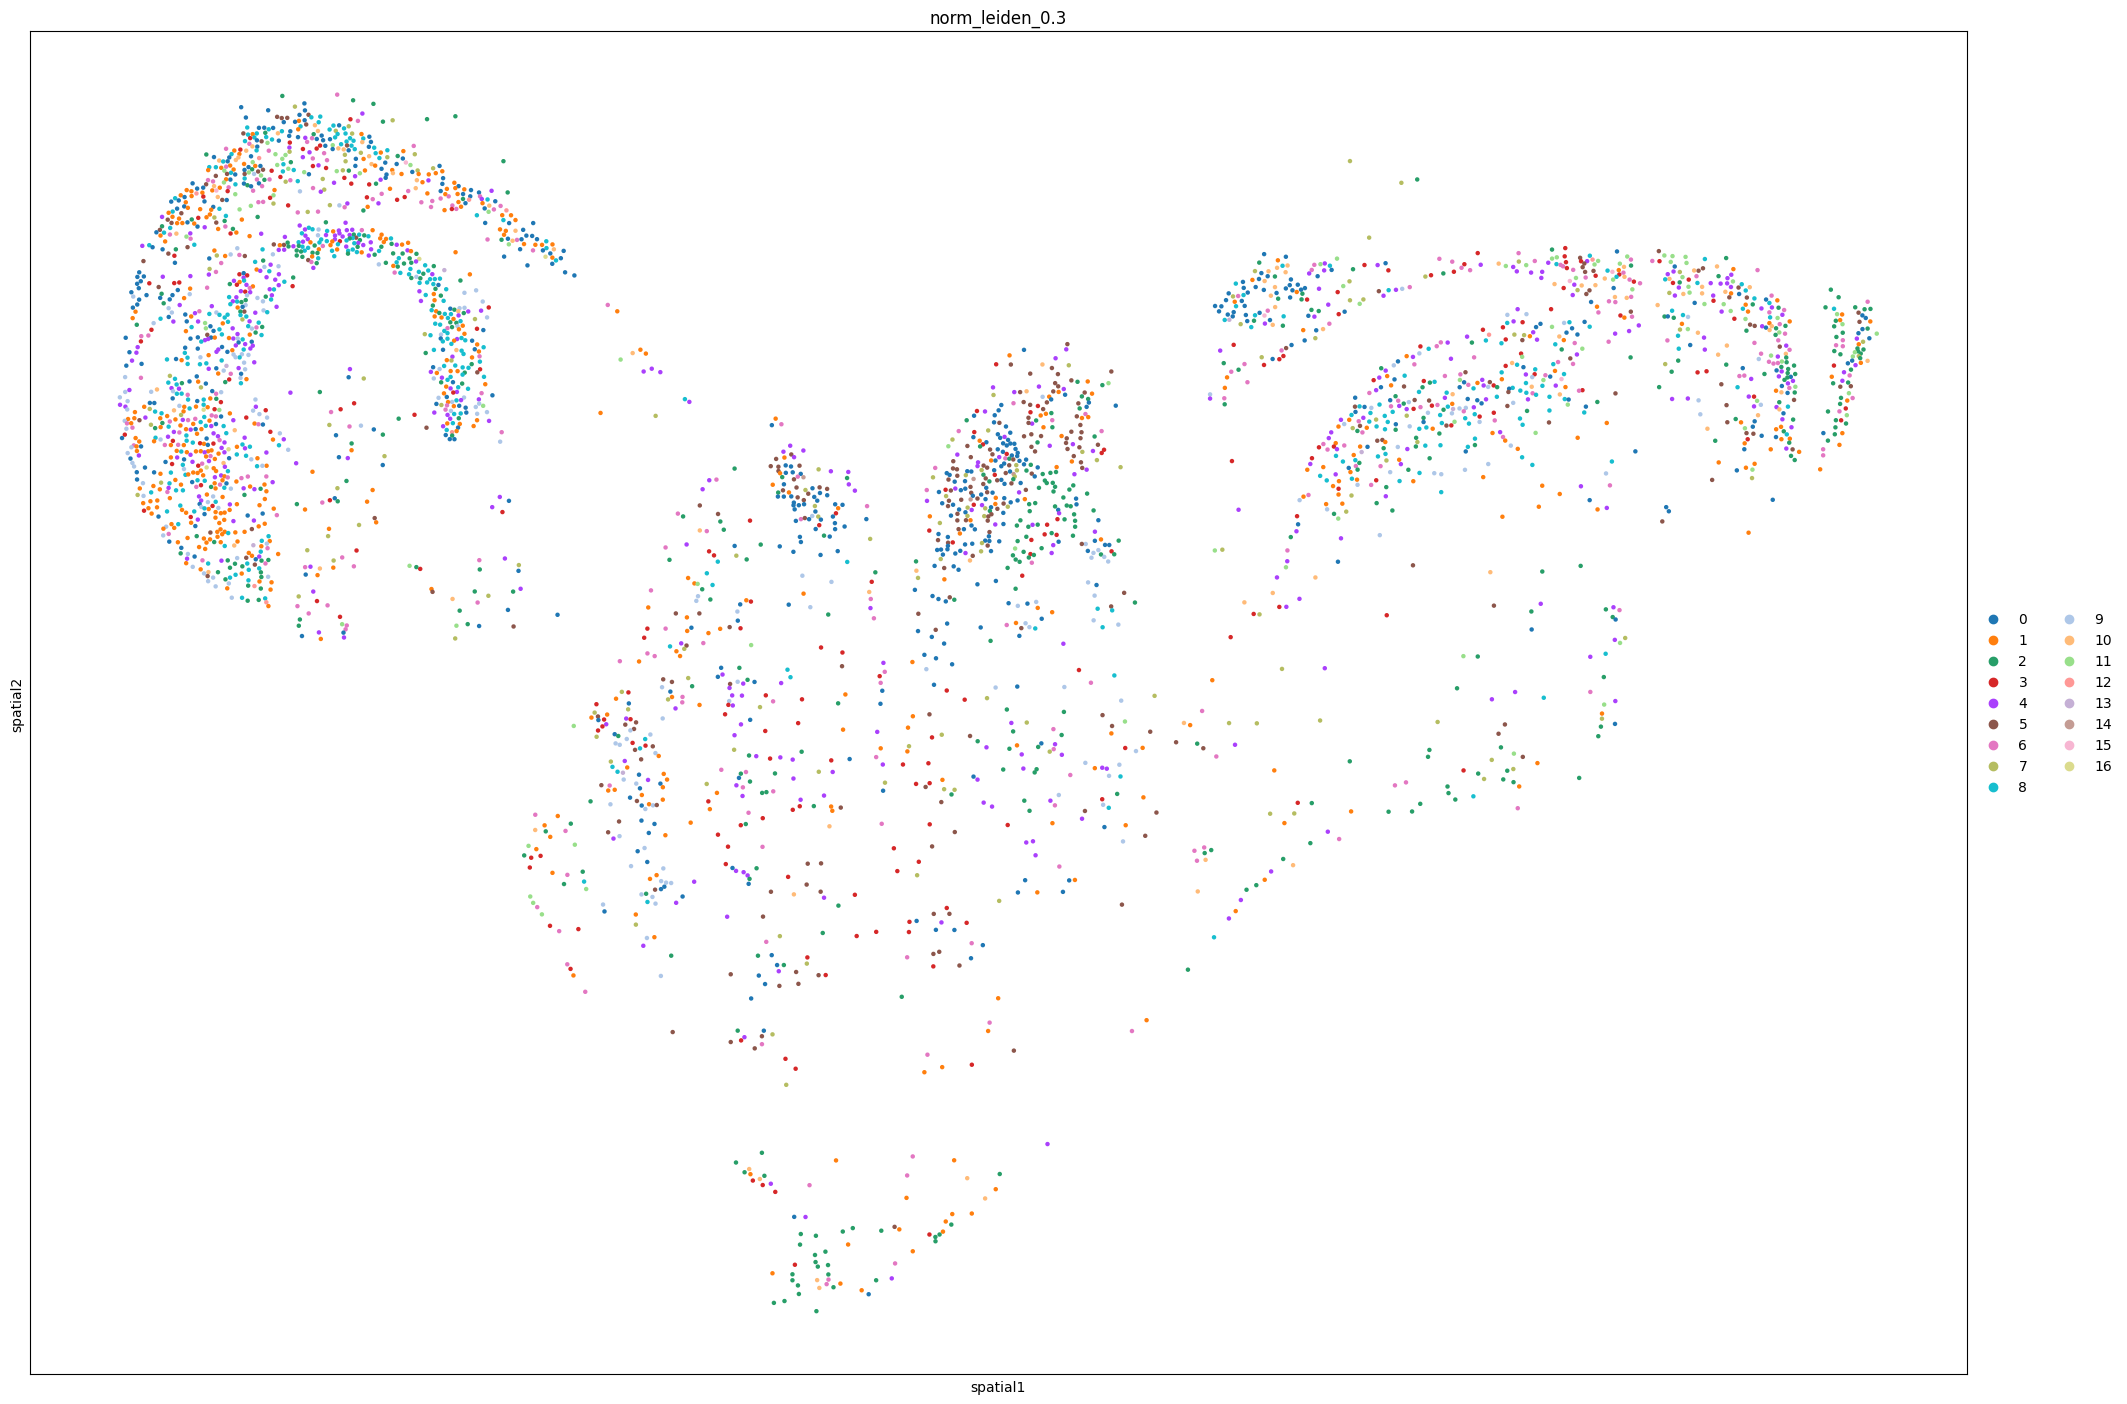

_R 2 Corrected


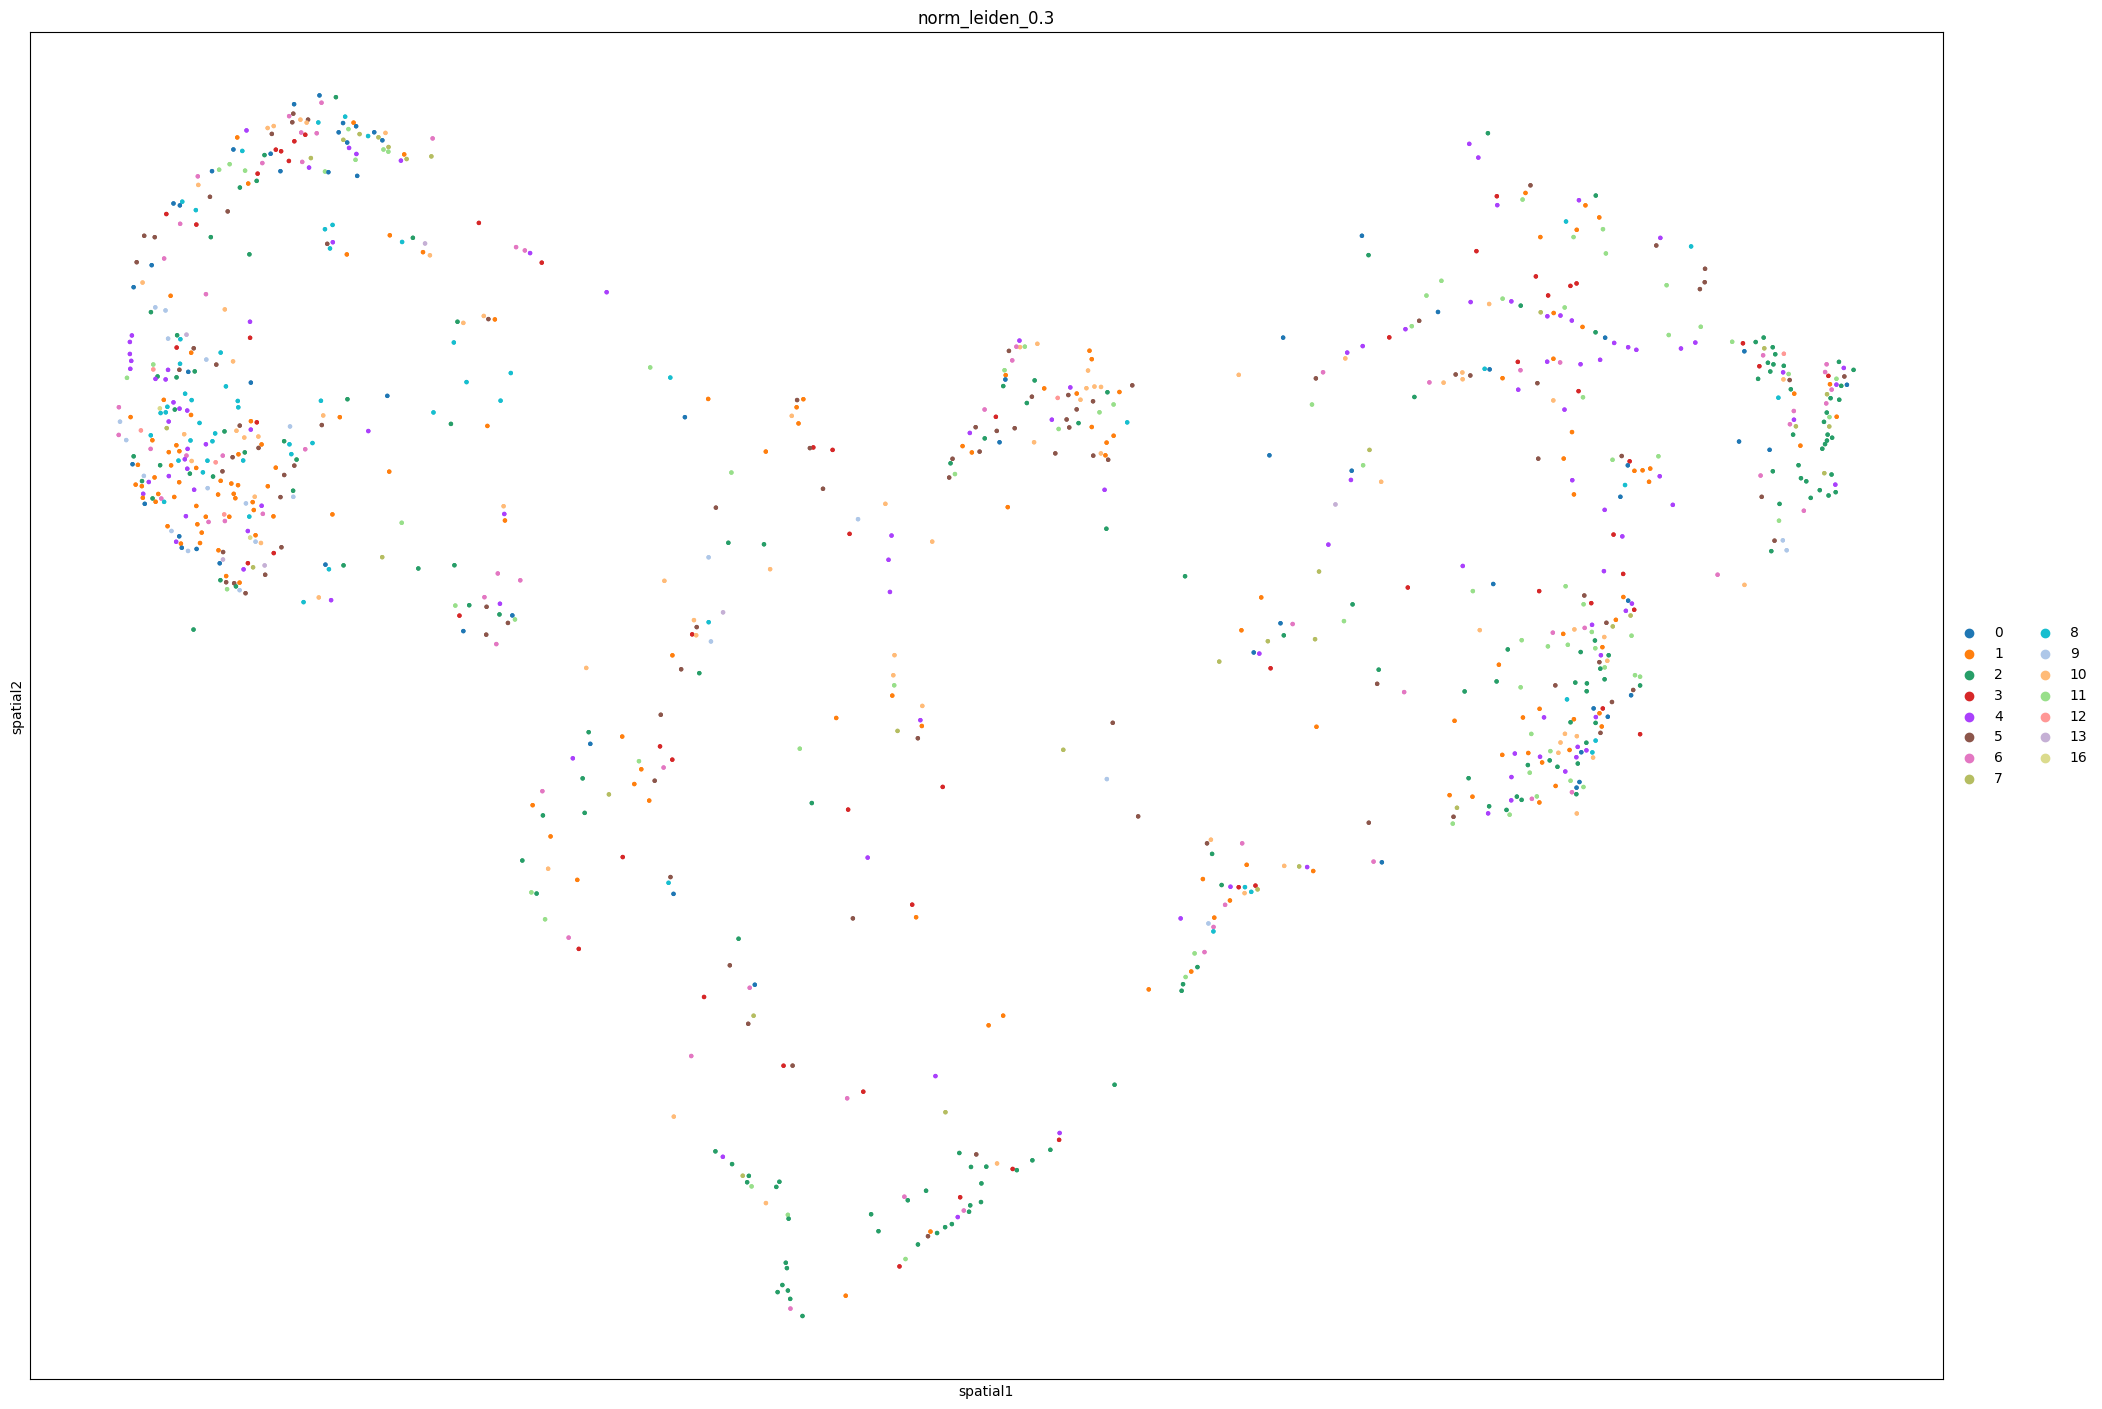

_R 3 Corrected


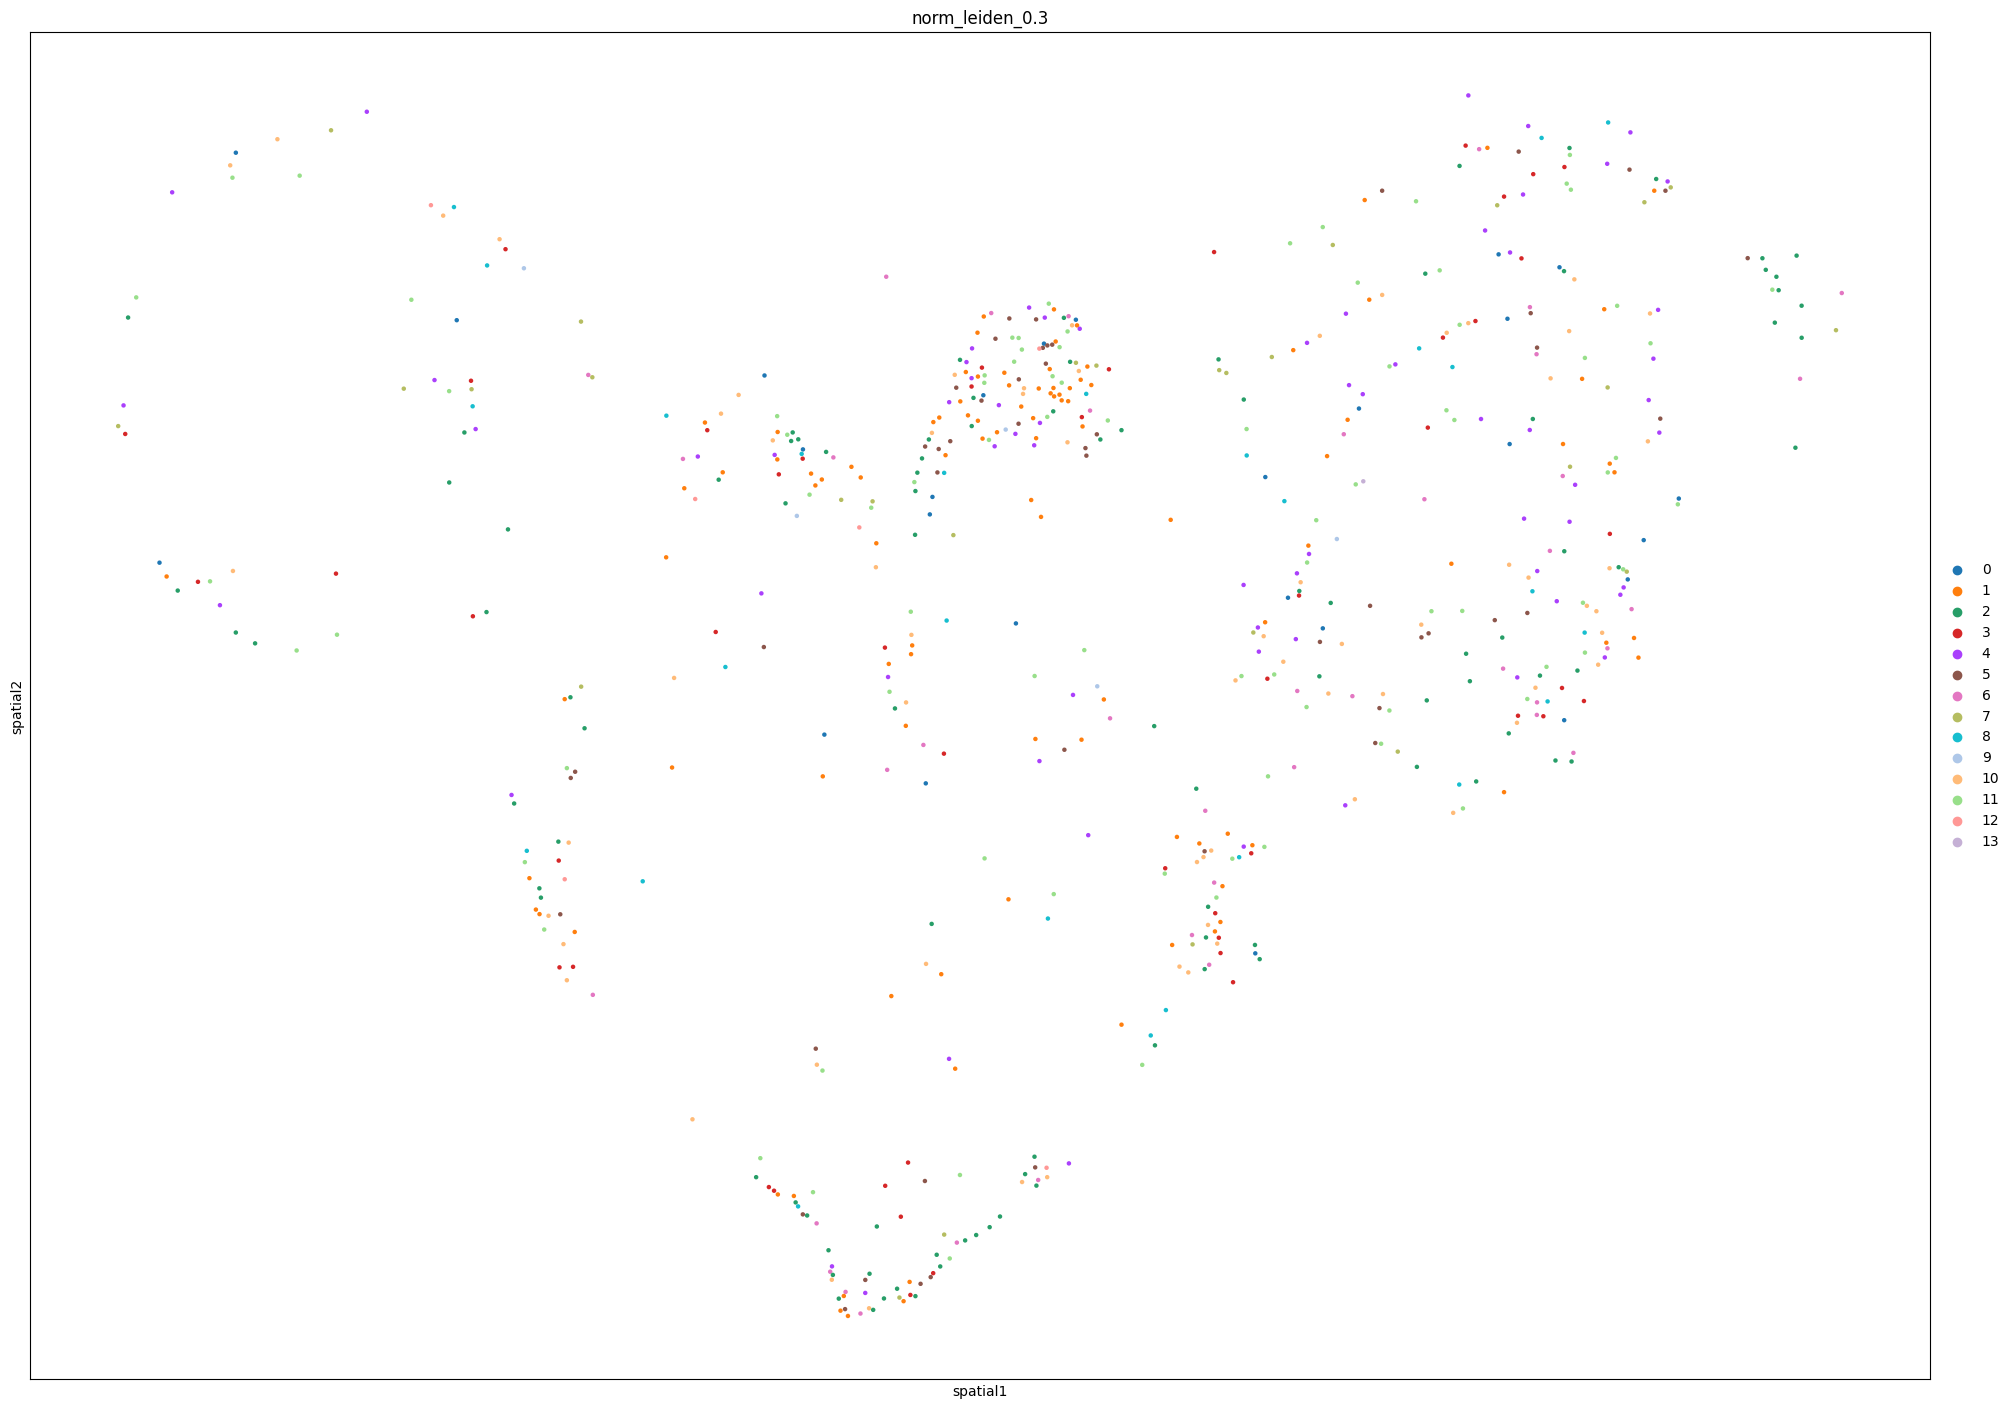

_R 4 Corrected


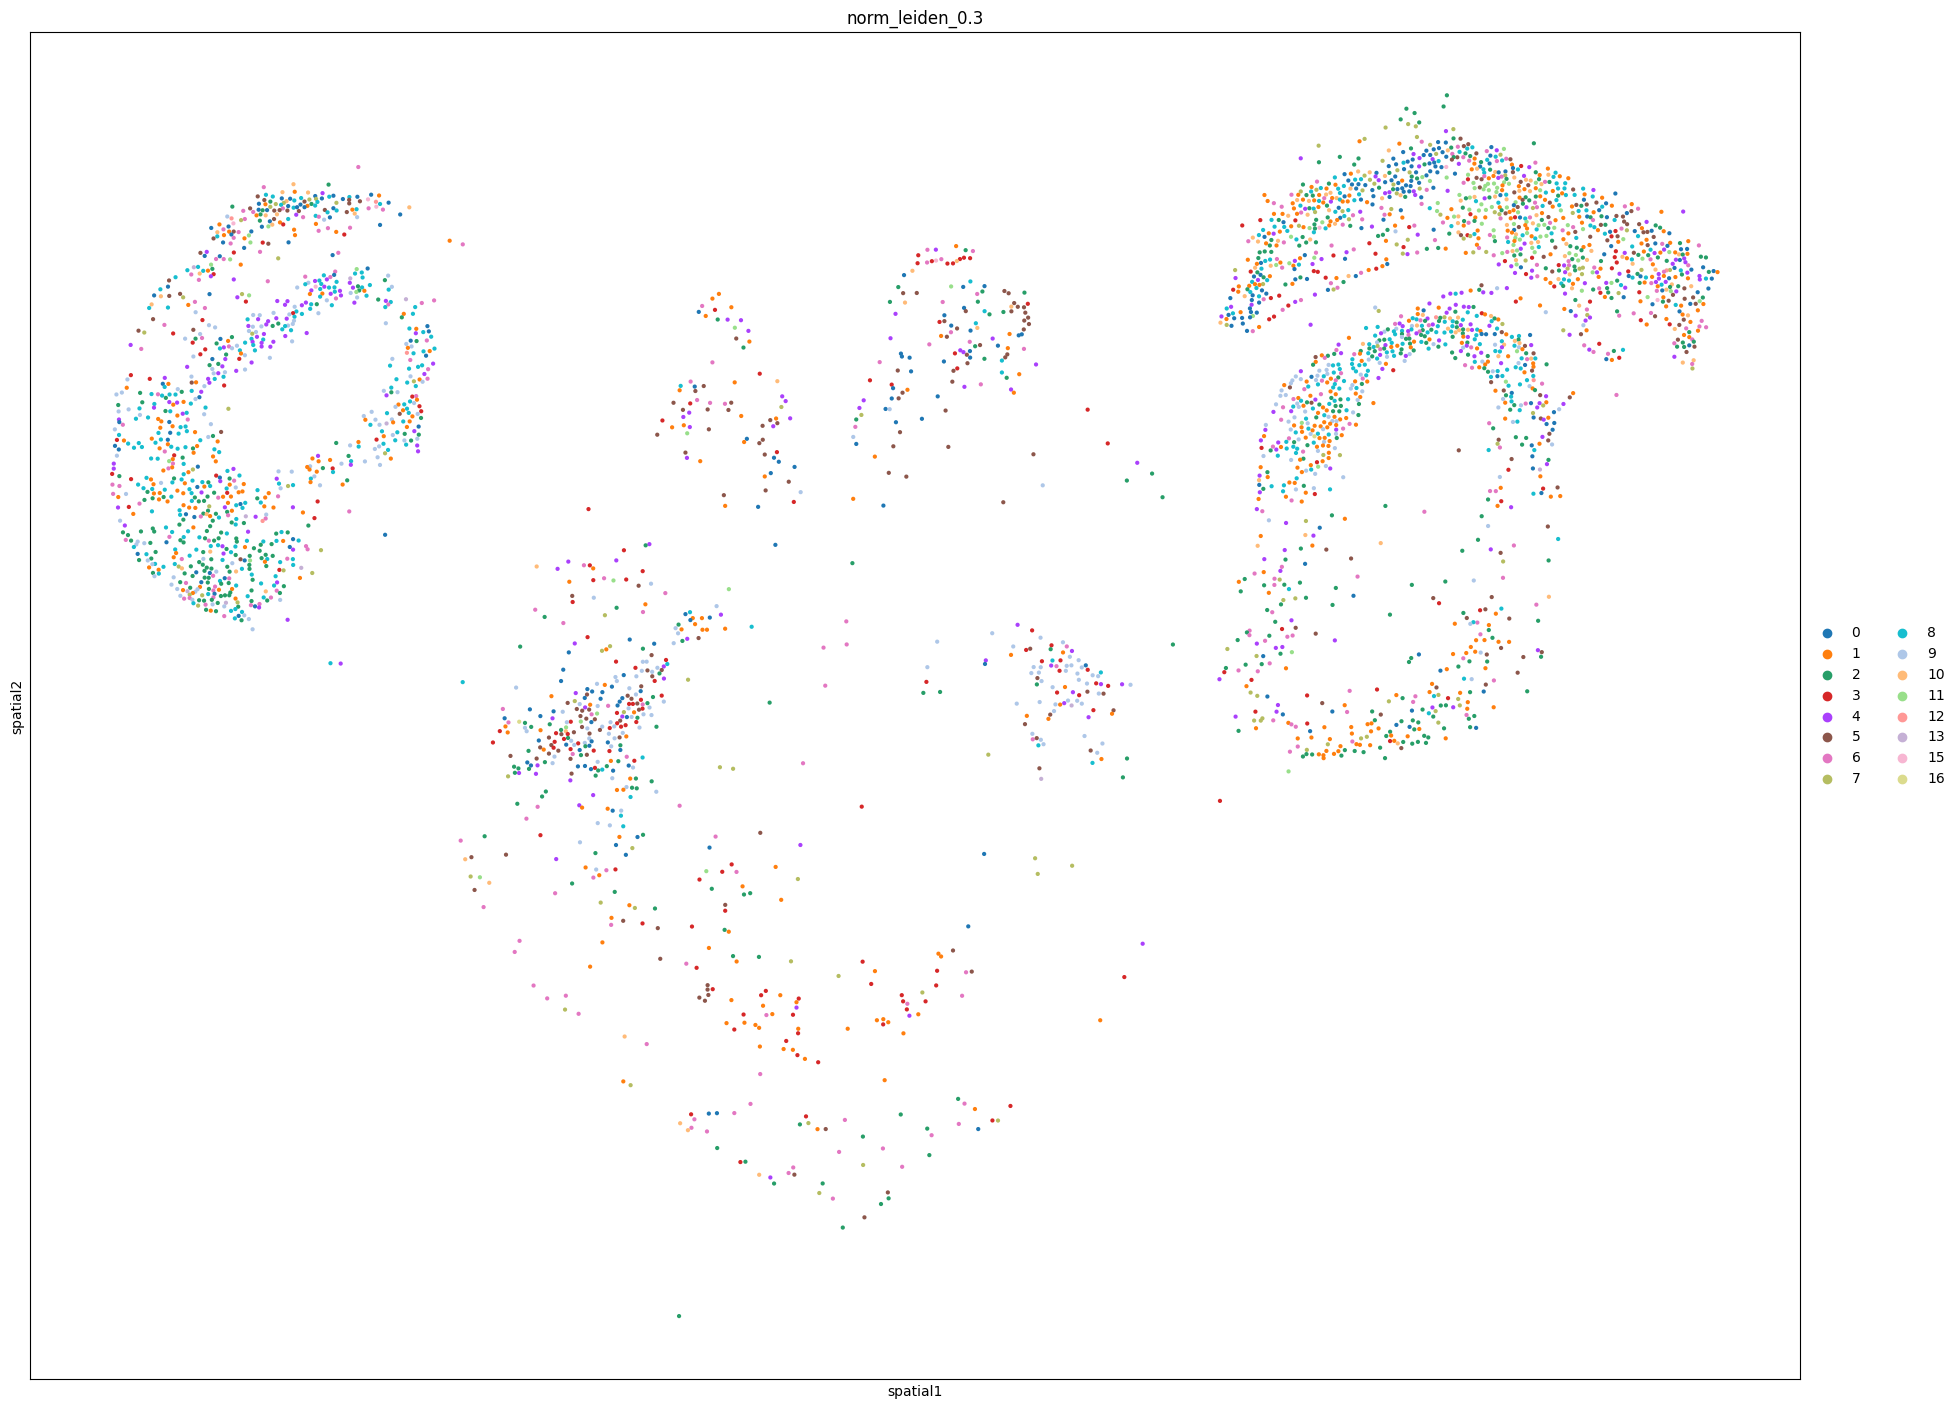

_R 5 Corrected


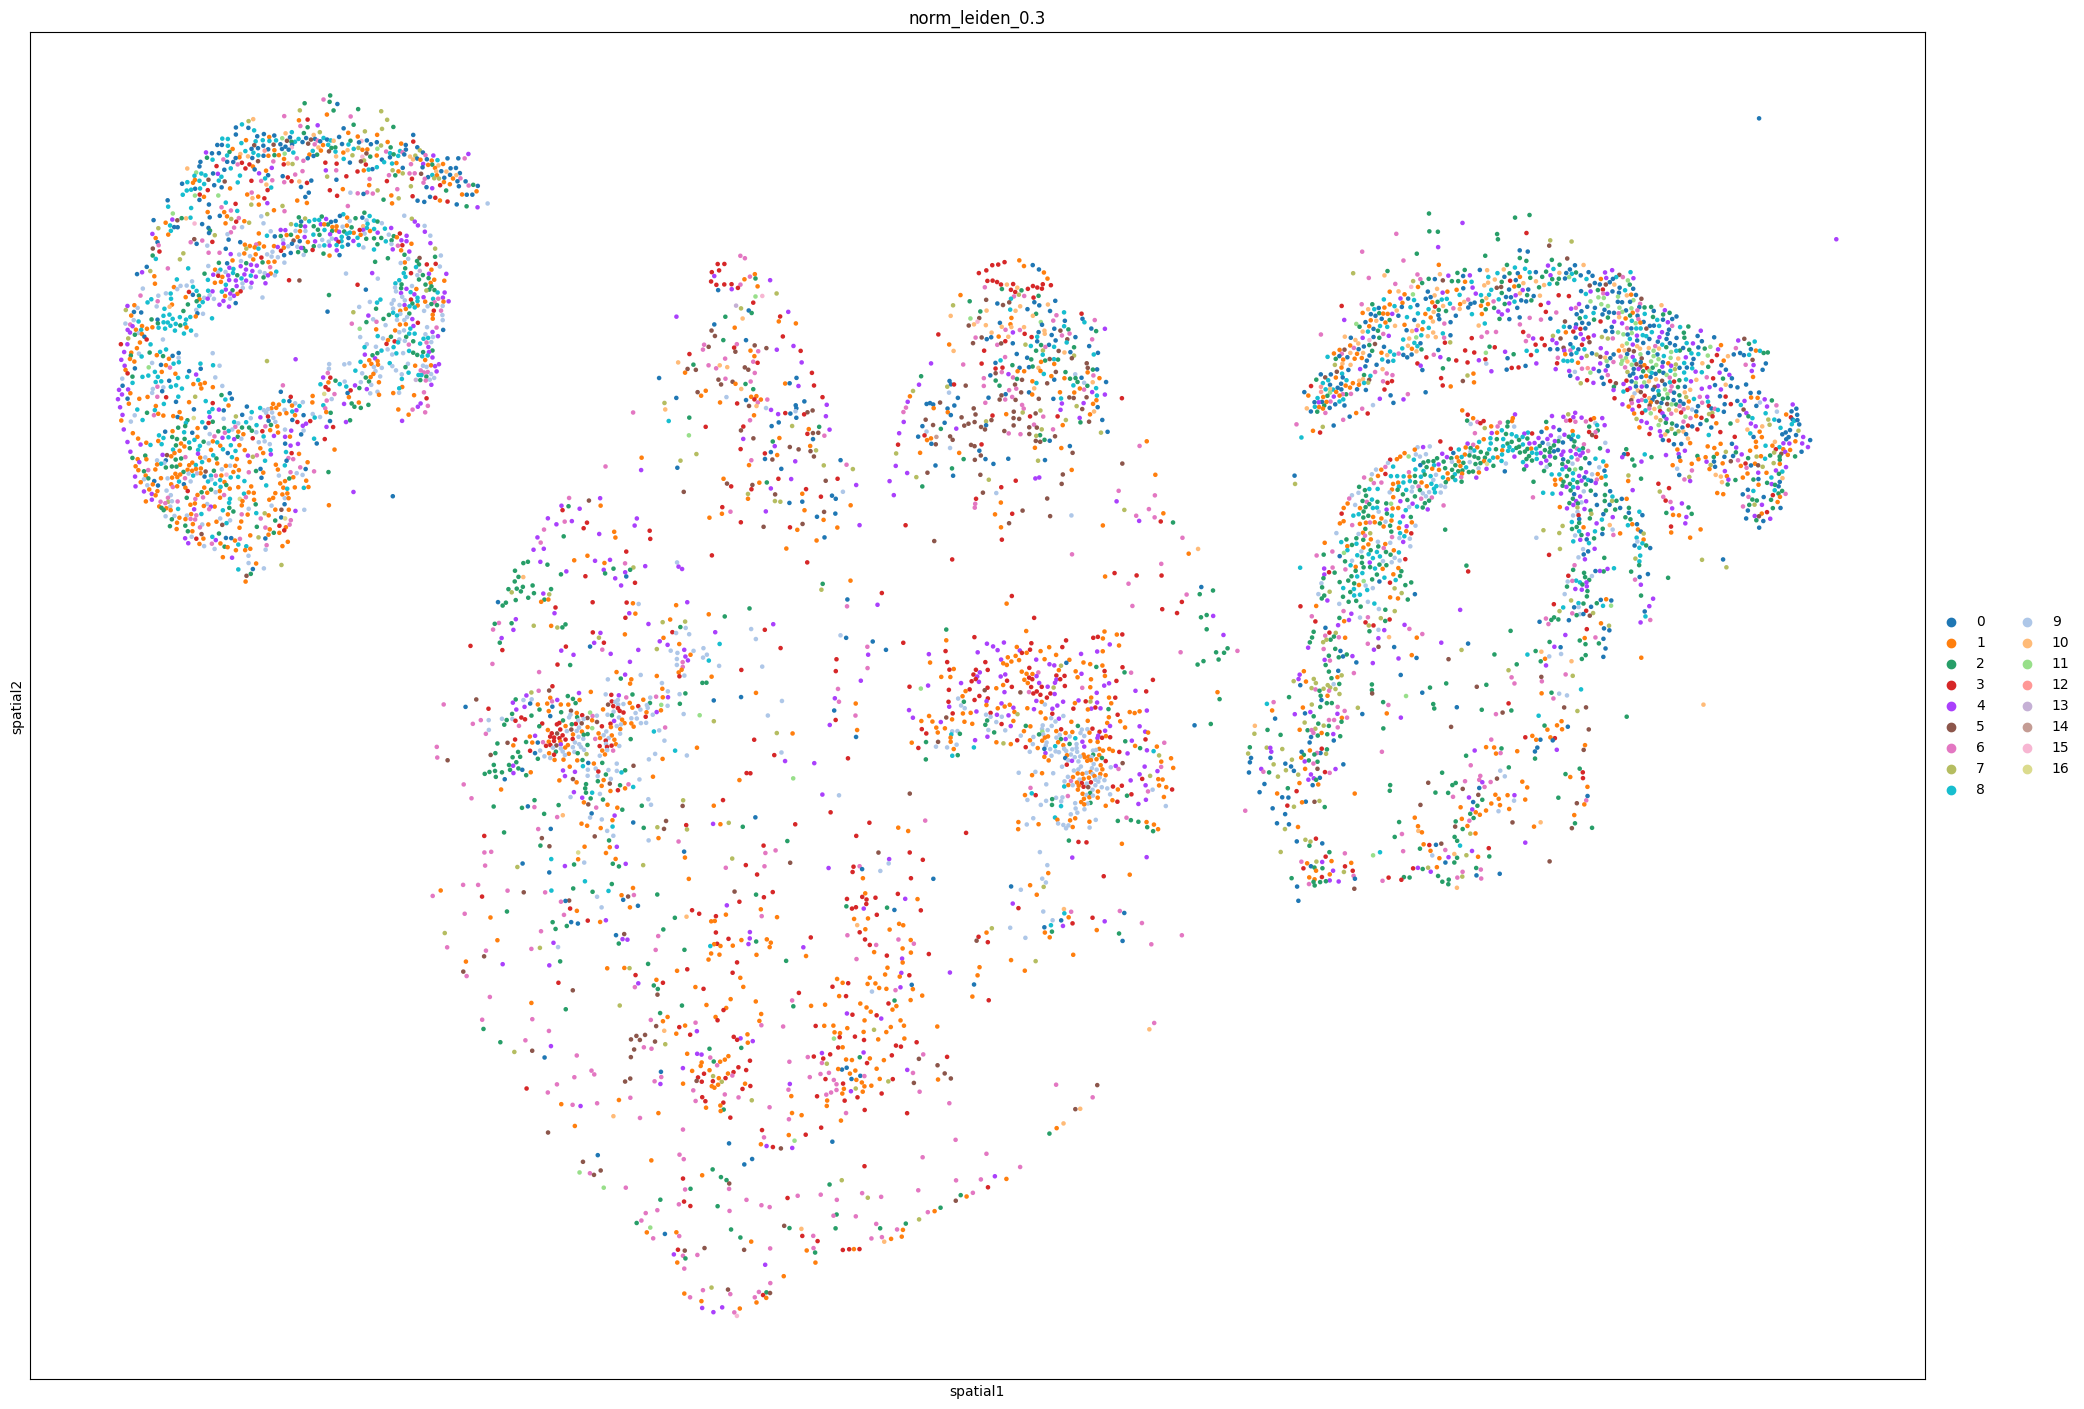

_R 6 Corrected


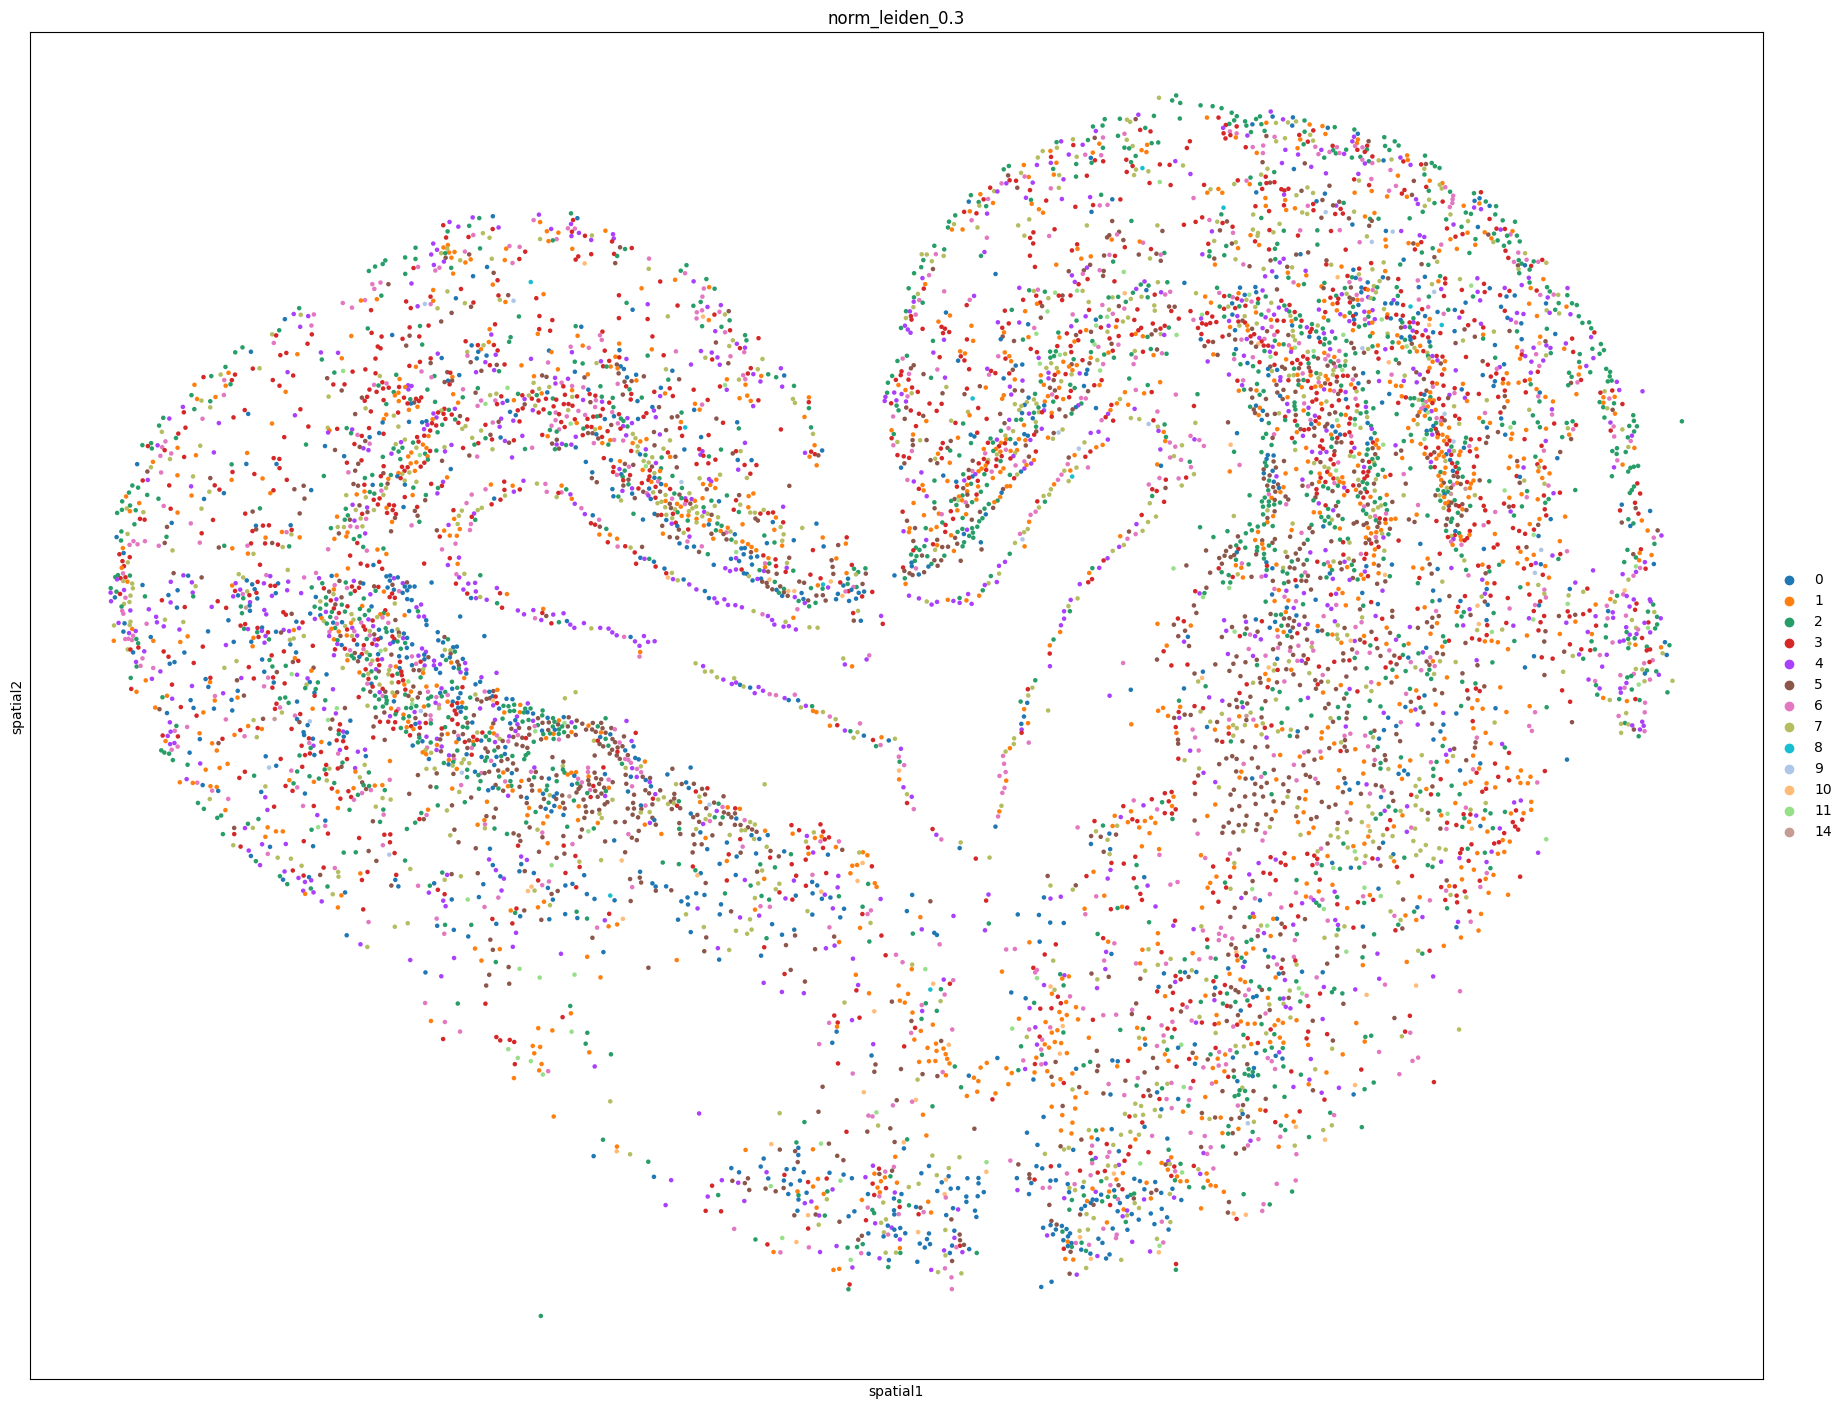

_R 7 Corrected


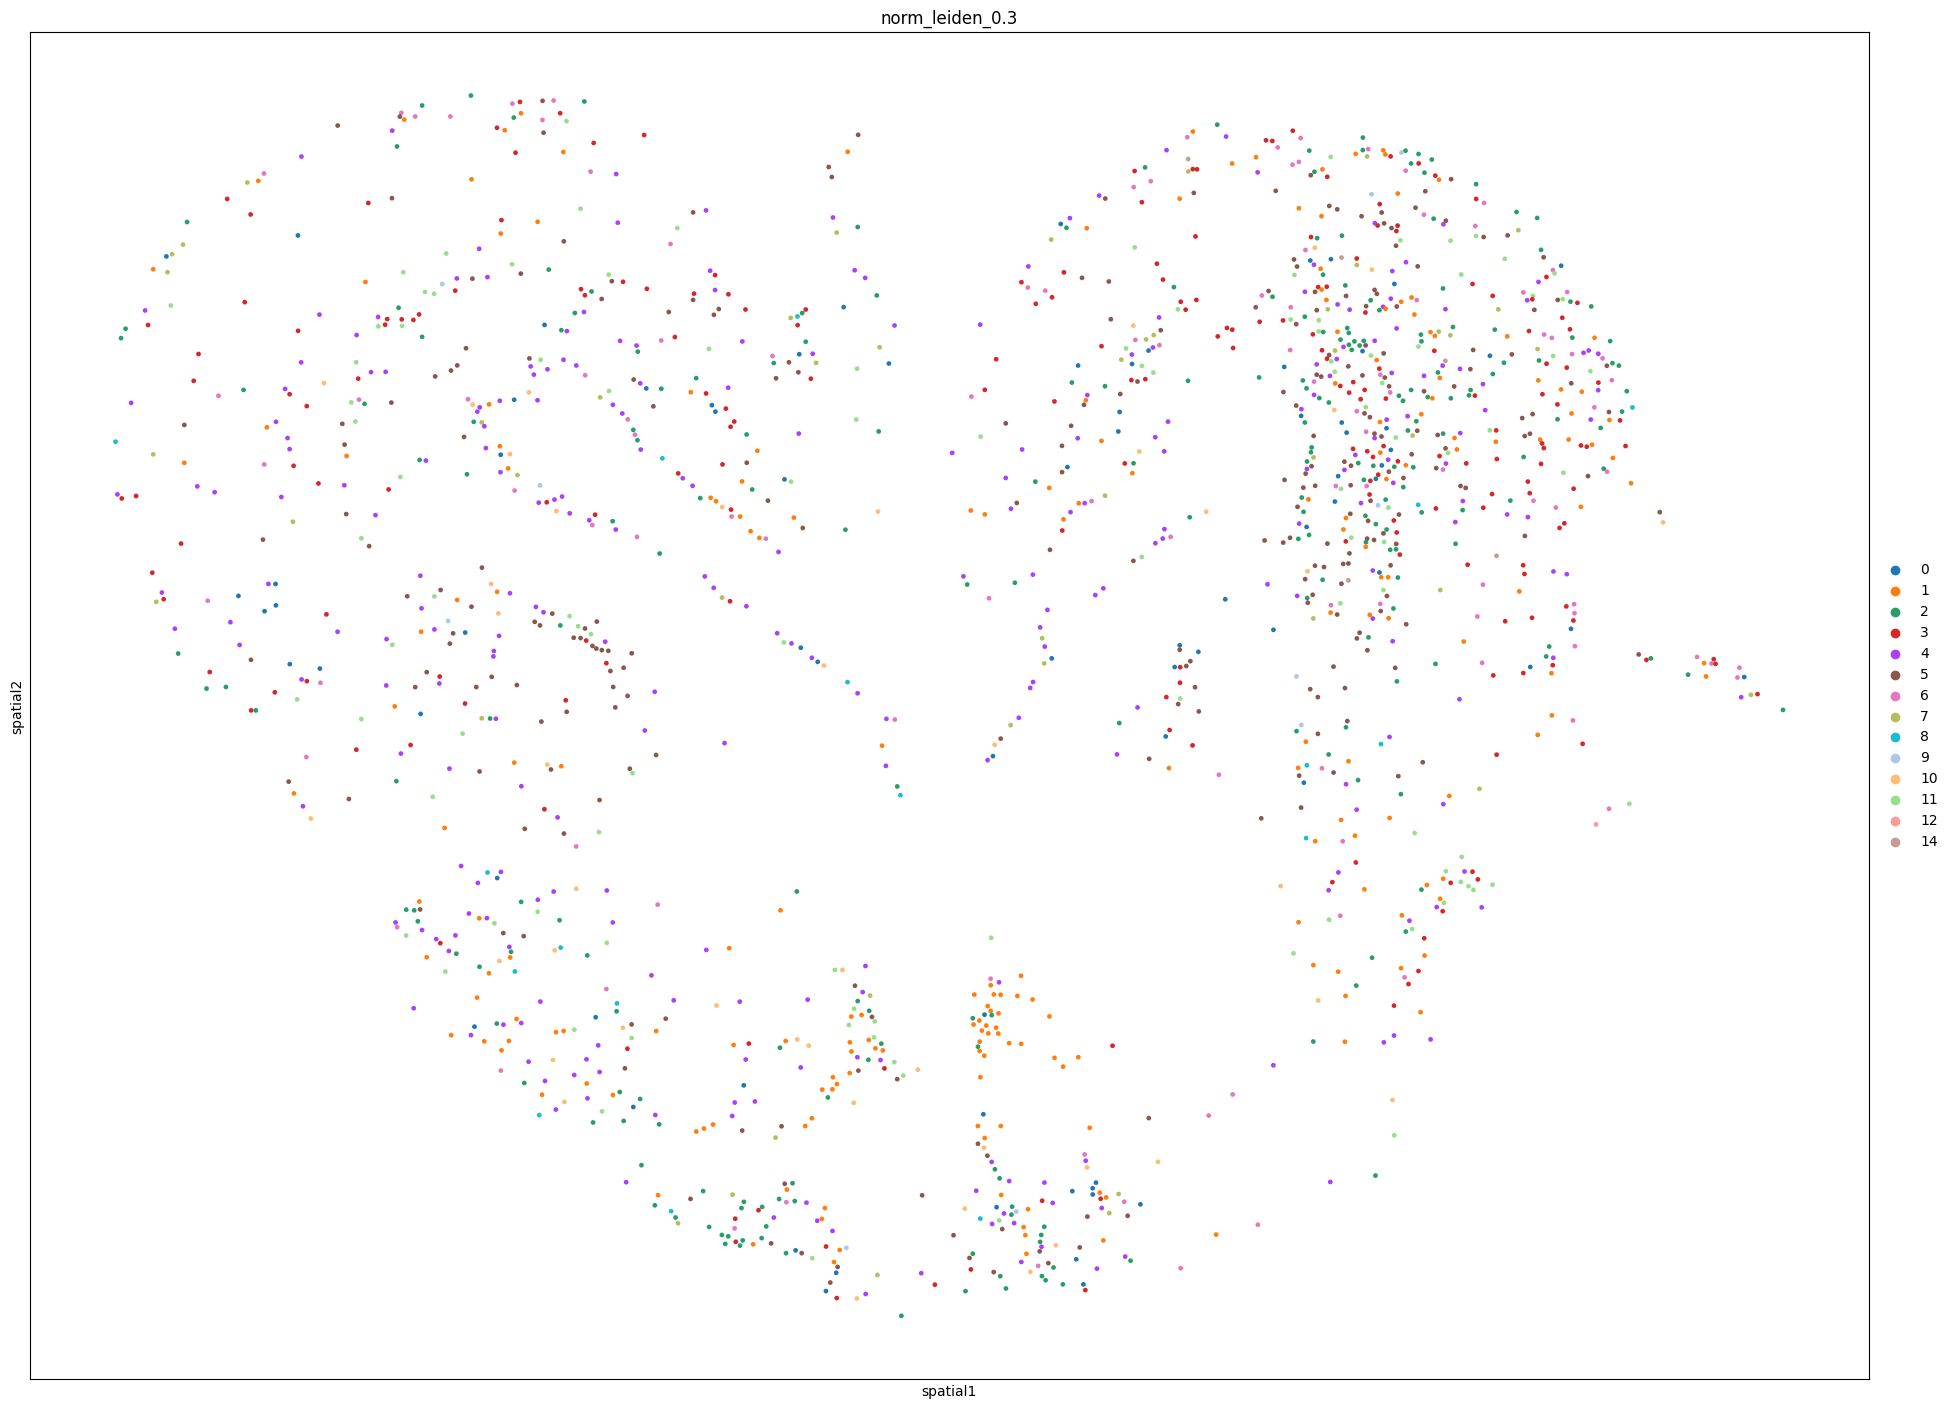

_R 8 Corrected


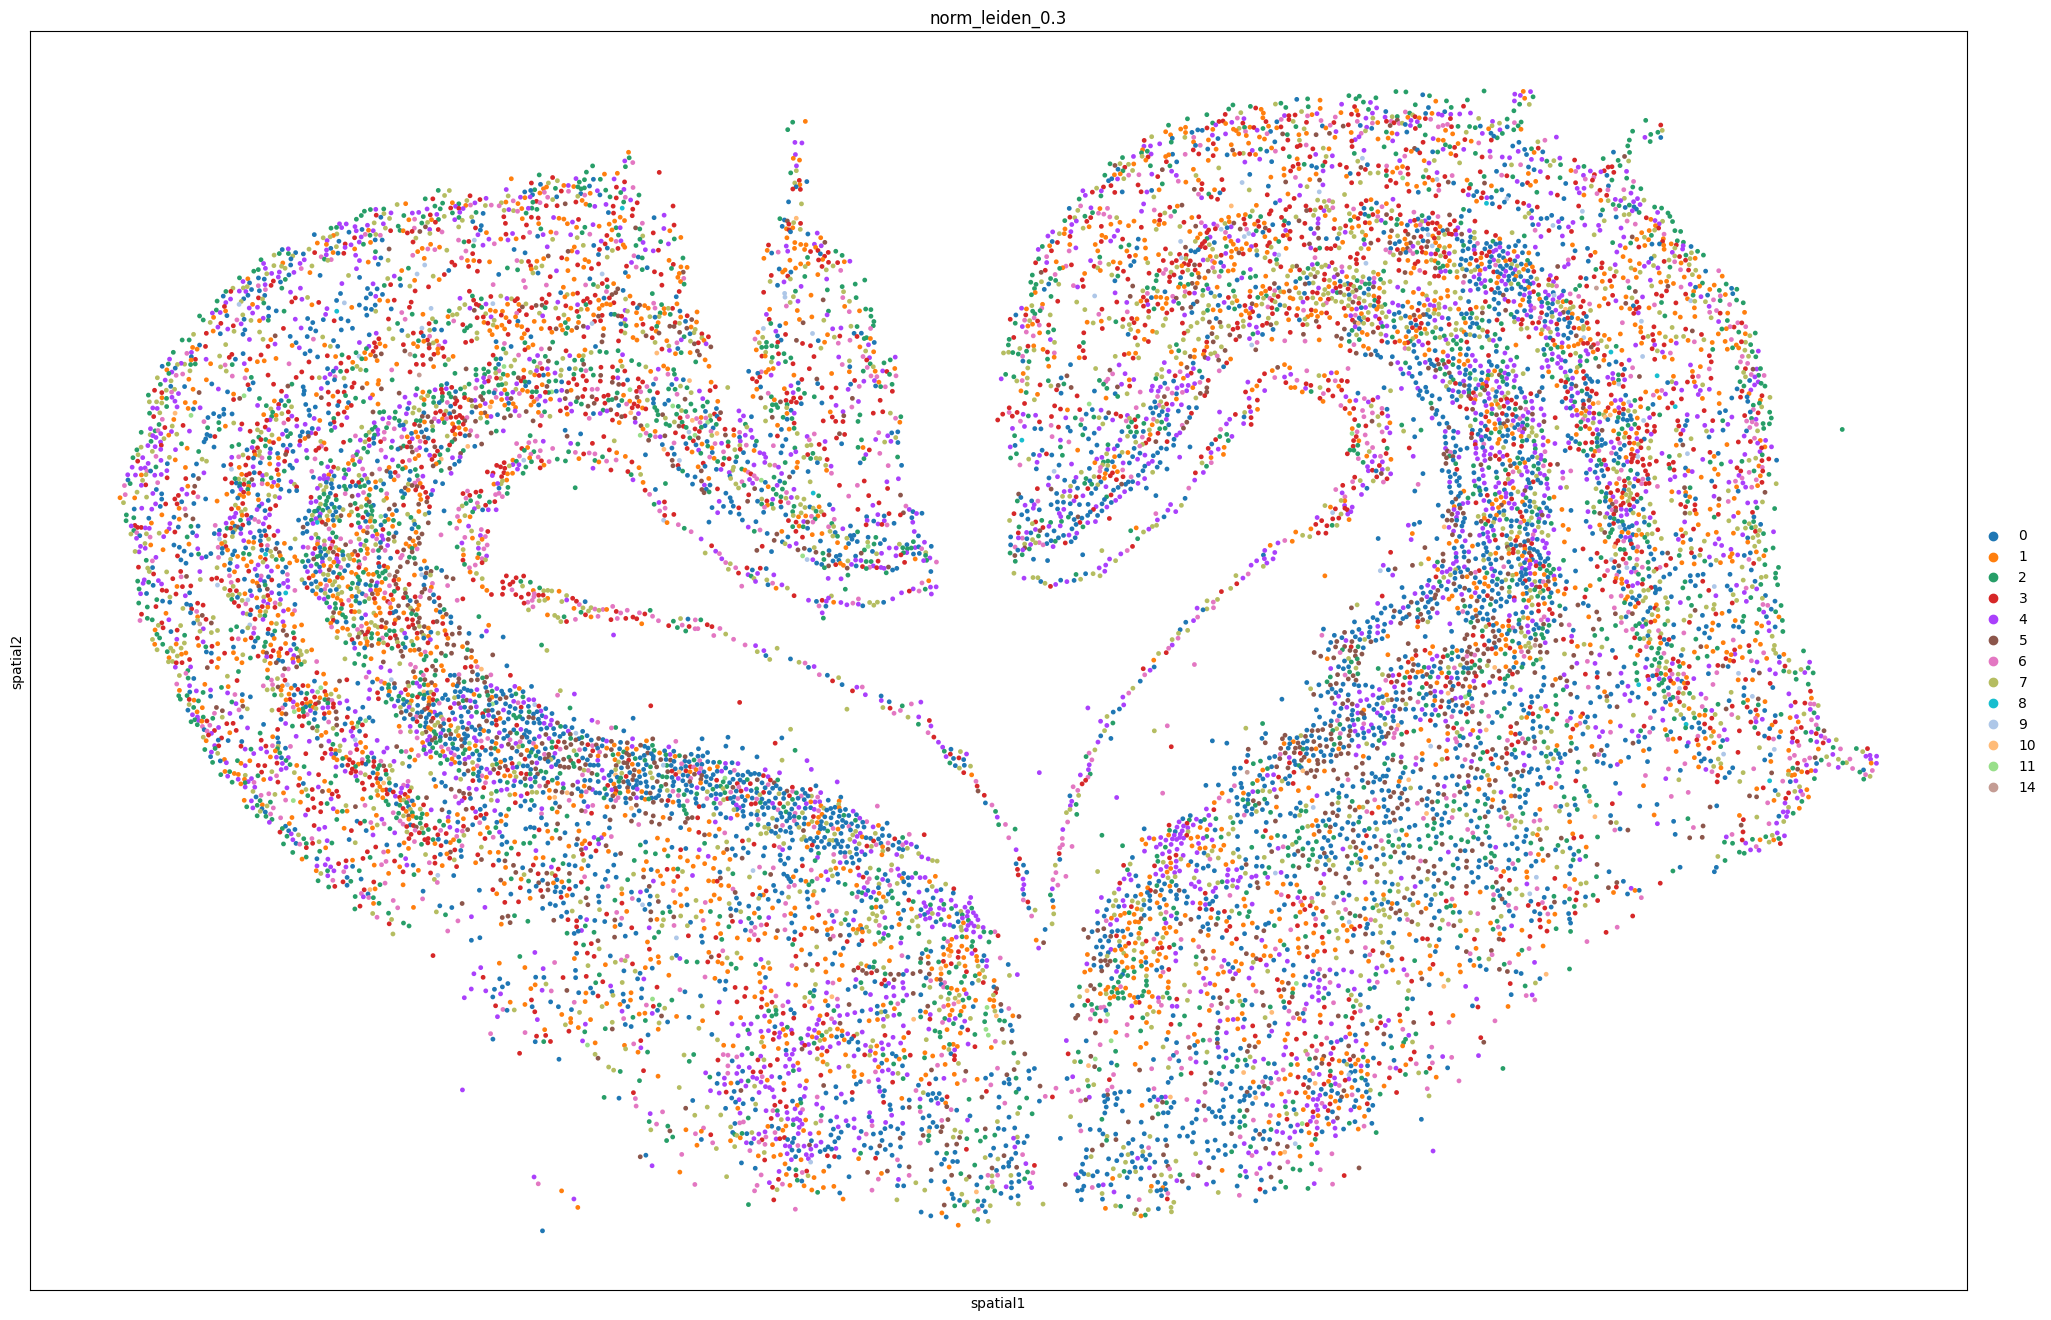

_R 9 Corrected


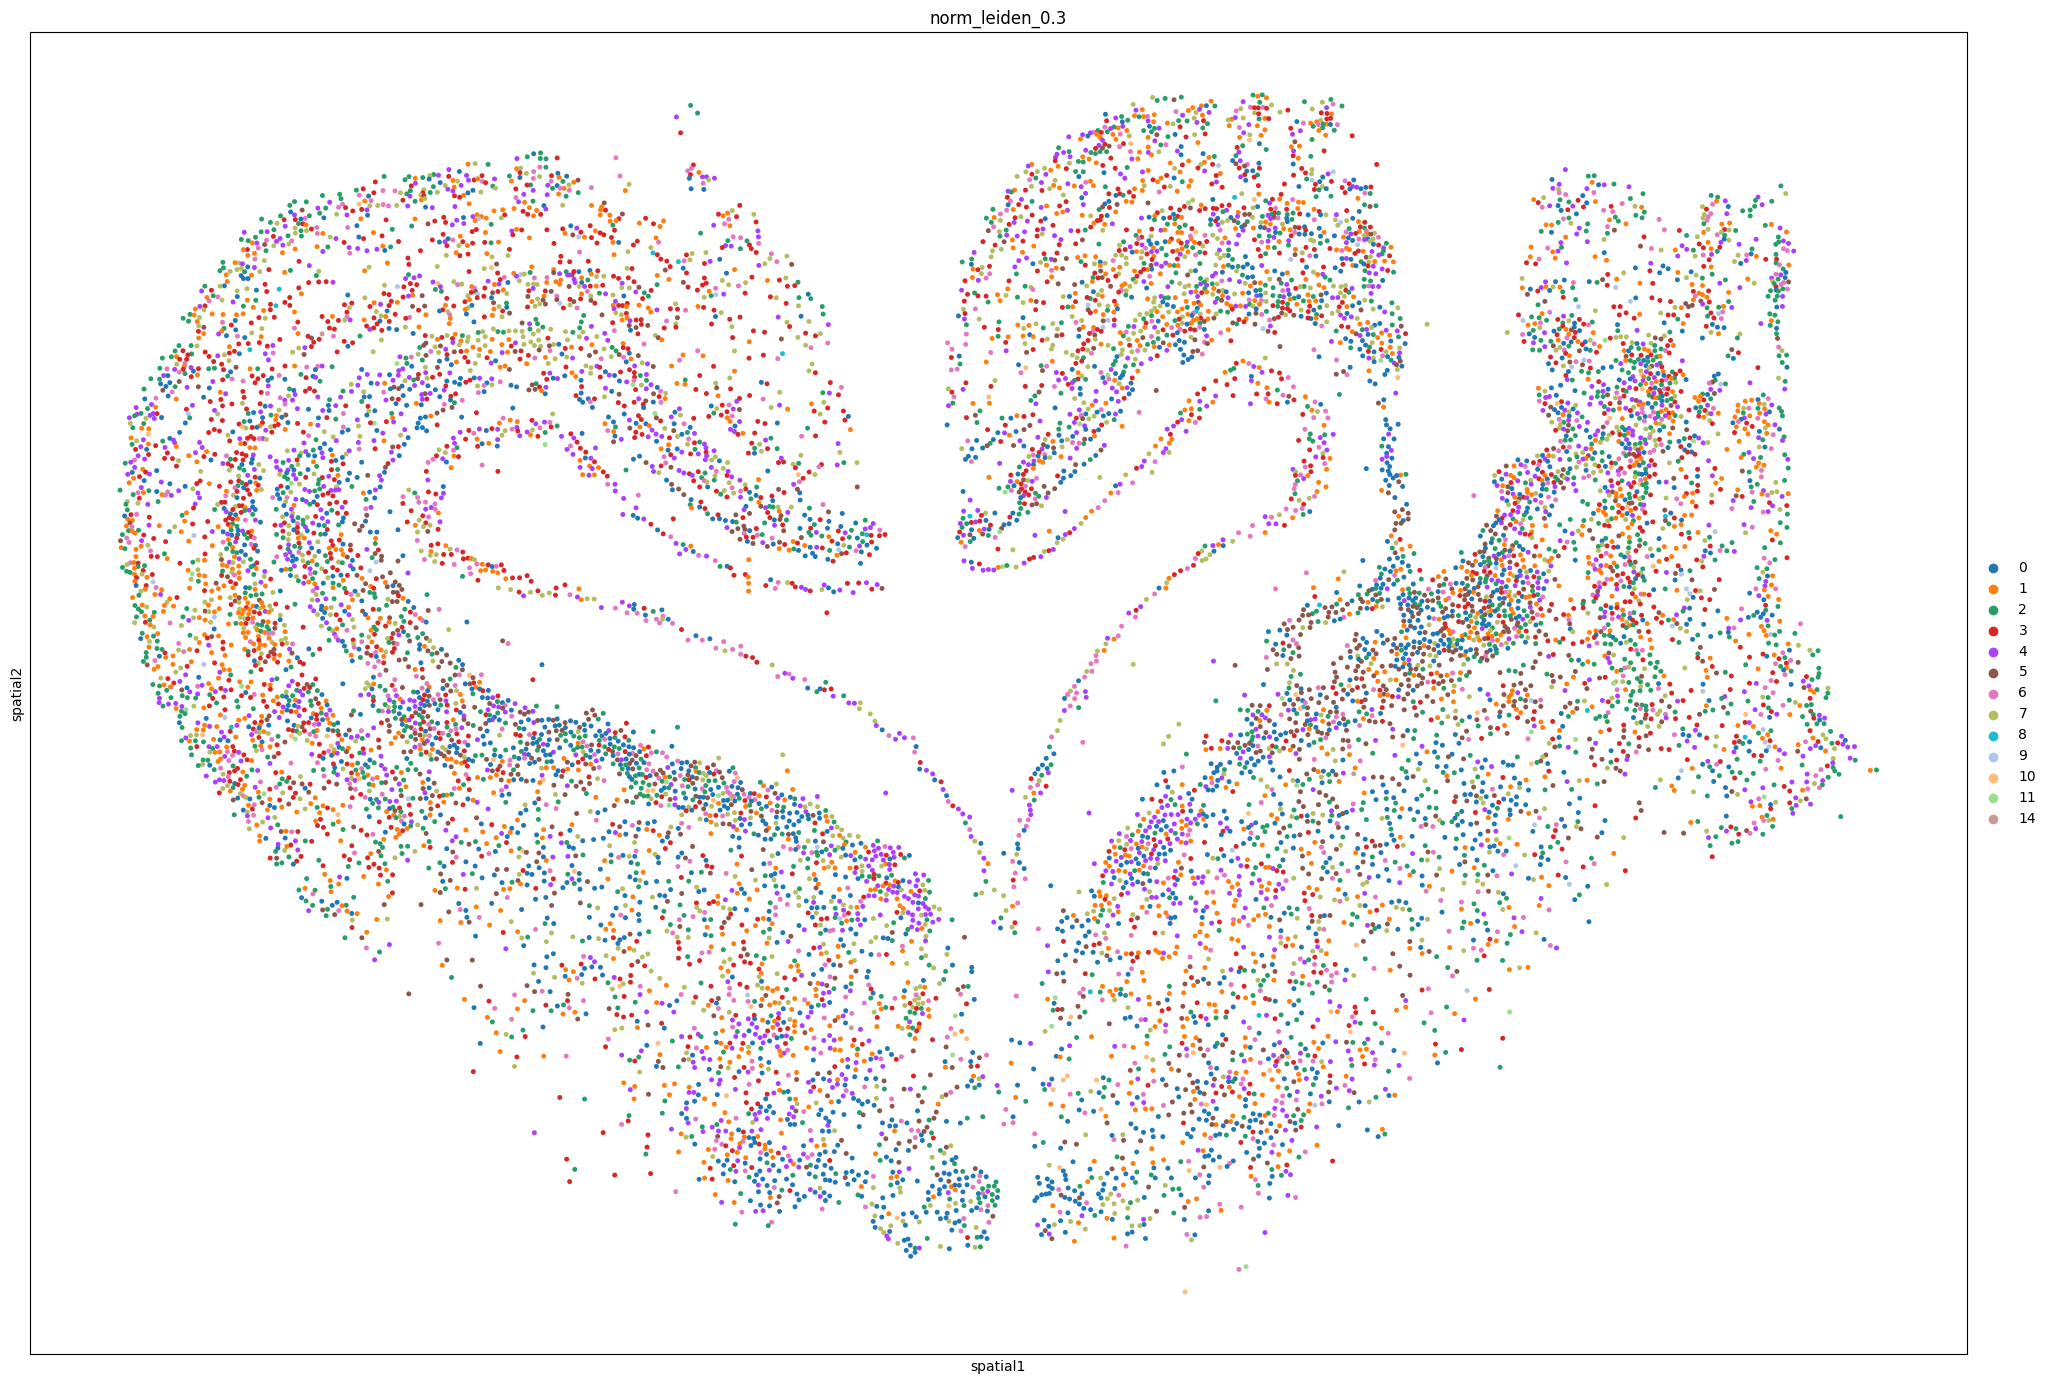

In [210]:
cluster = 'norm_leiden_0.3'
for sample in ad.obs['sample_id'].unique():
    print(sample)
    ad_int = ad[ad.obs['sample_id'] == sample]    
    with plt.rc_context({'figure.figsize': (25, 17.5)}):
        sc.pl.spatial(ad_int,color=cluster ,spot_size=30)




## Which genes are good markers of your ISS clusters?
By running the following code blocks, you can see which genes characterise each one of the ISS clusters inferred above, and generate different plots showing essentially the same information in less or more condensed format.

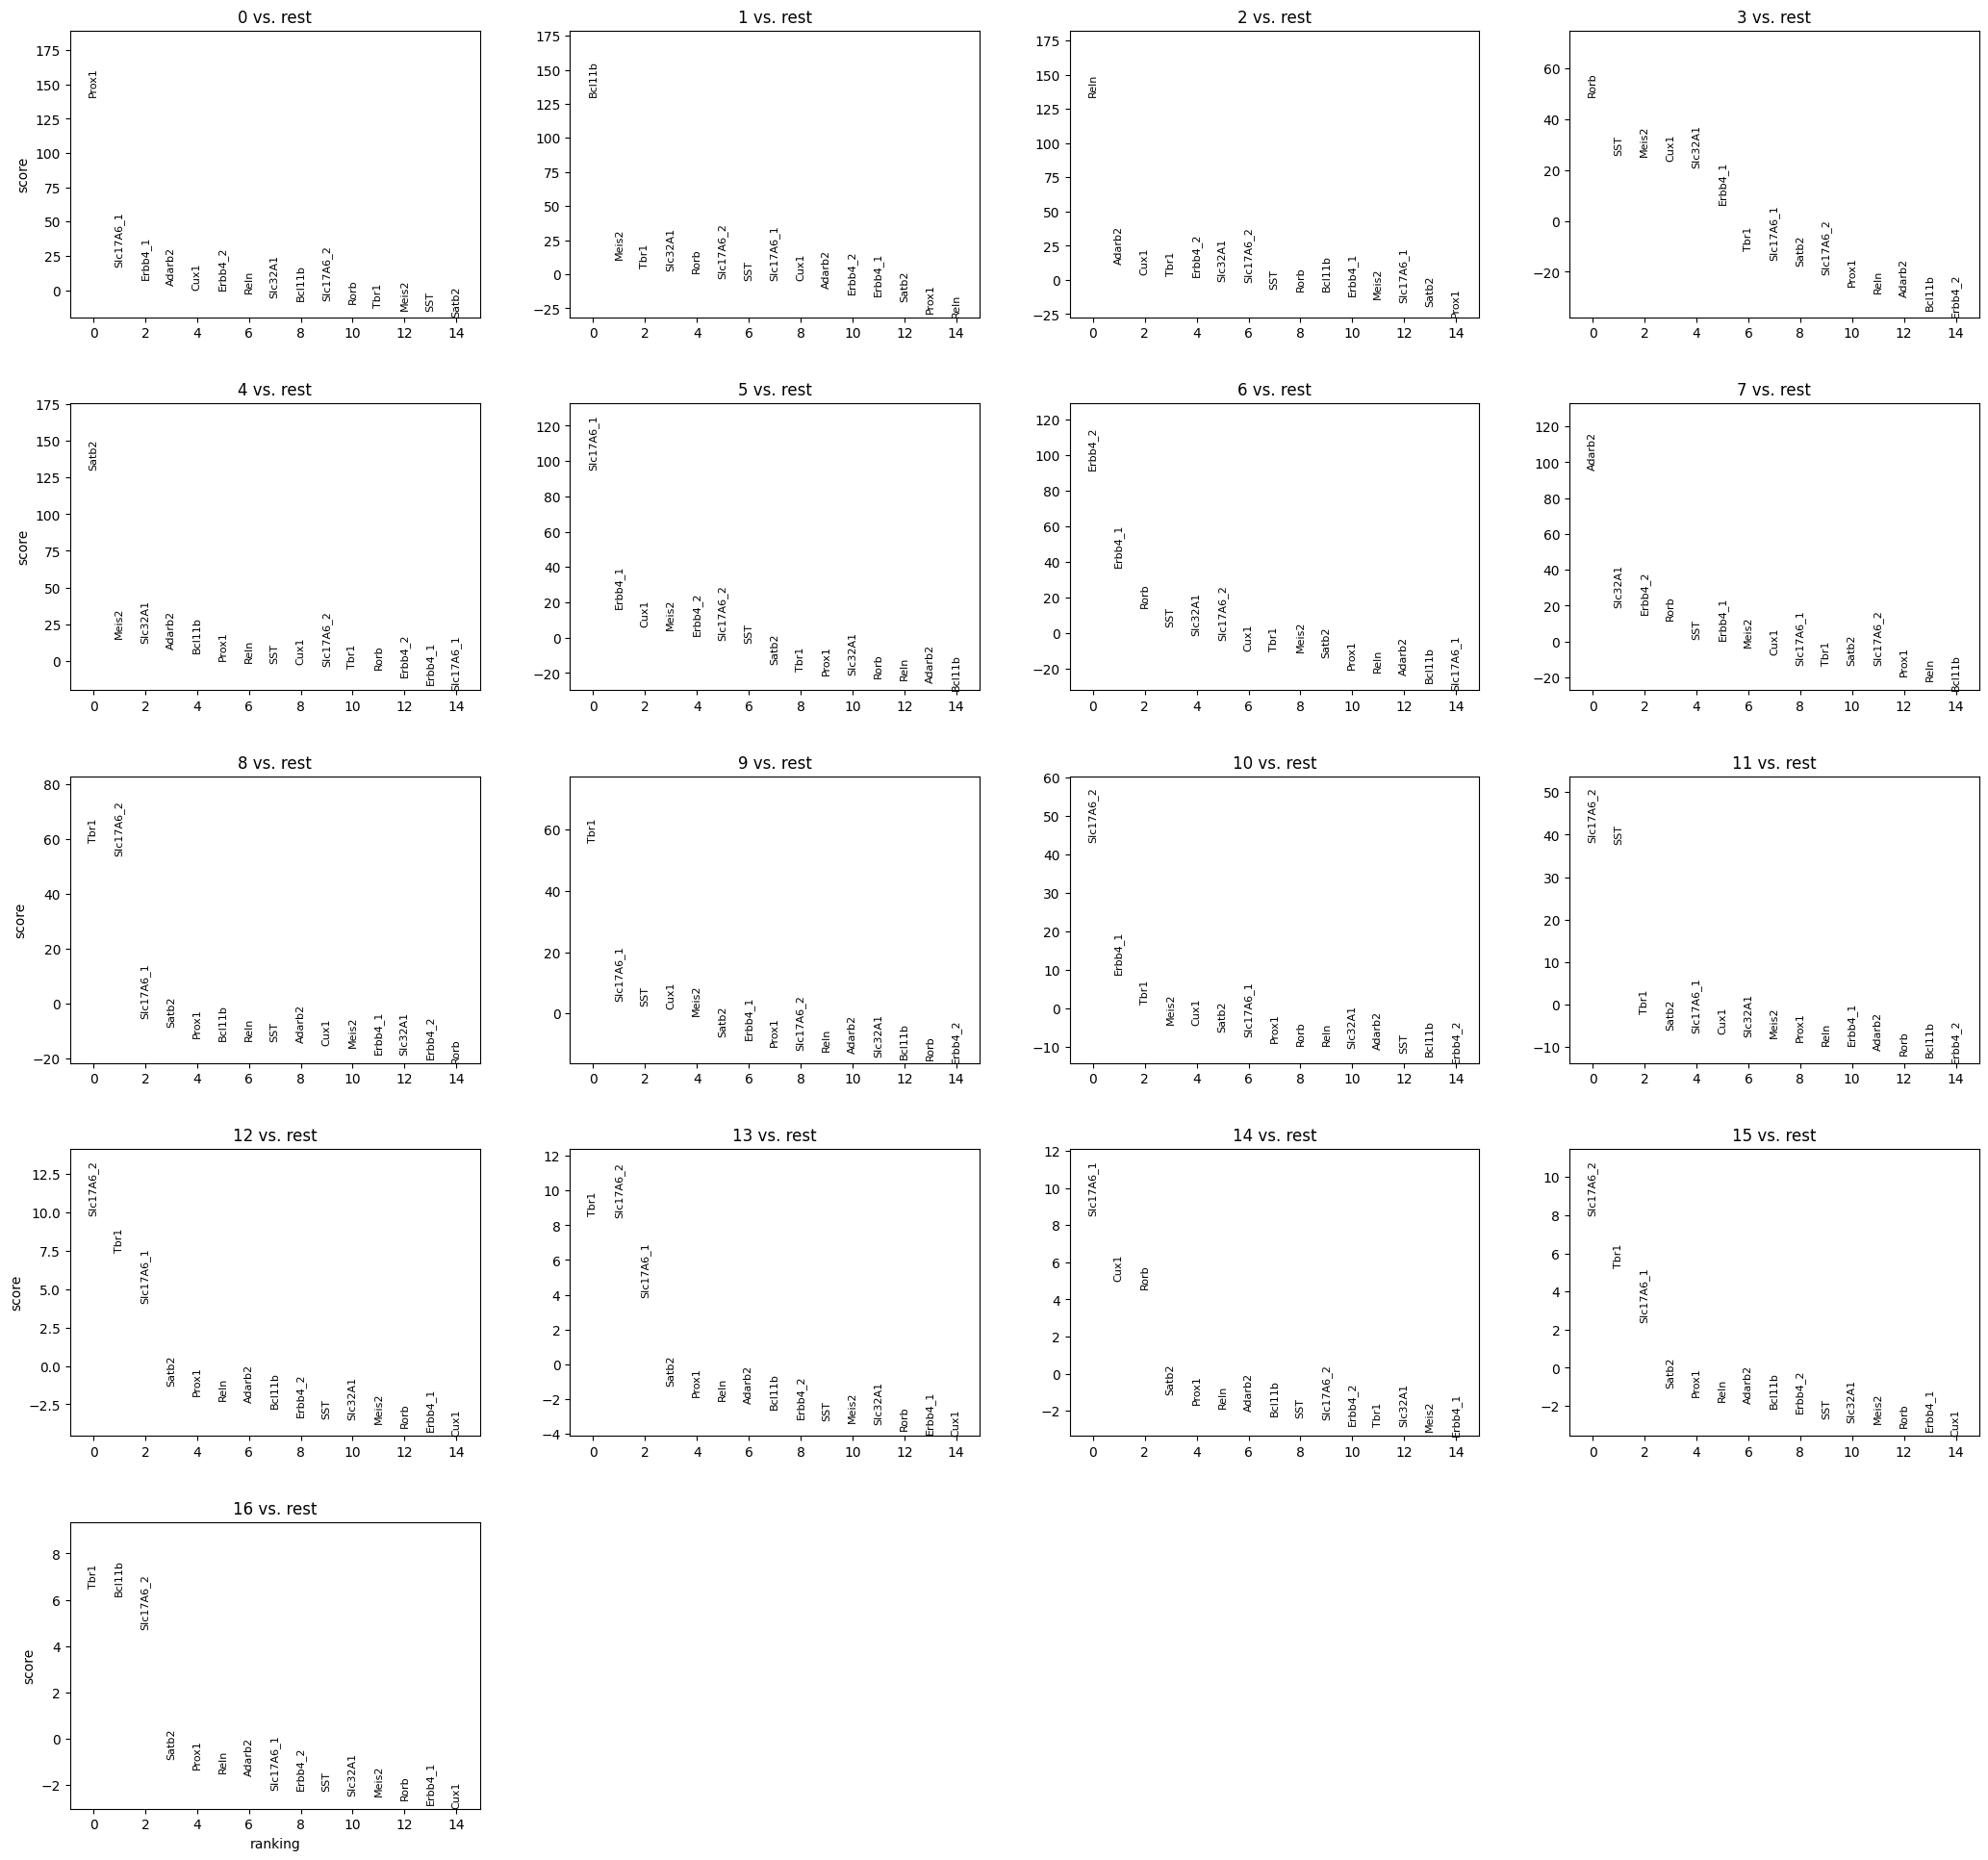

In [211]:
sc.tl.rank_genes_groups(ad, cluster, method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(ad, n_genes=15, sharey=False, key="wilcoxon")

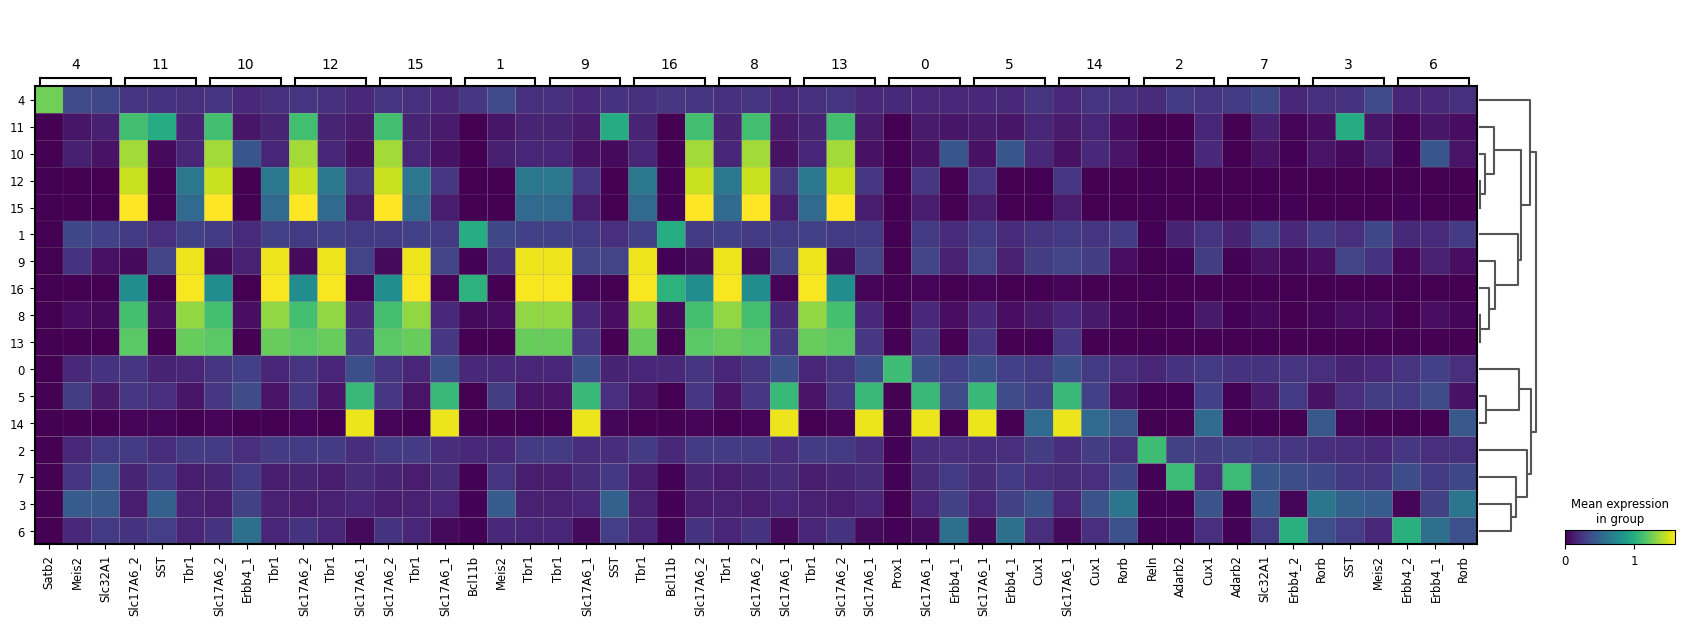

In [213]:
plt.rcdefaults()
sc.pl.rank_genes_groups_matrixplot(ad, n_genes=3, key='wilcoxon', groupby=cluster, cmap = 'viridis', )

## The following code allows to generate figures for each cluster individually.

By running the following code, you plot each cluster, one by one, for all the samples in a single figure, together with a short list of unique markers.



In [168]:
ad.obs['project'] = 'sc'

In [ ]:
for cluster_ in sorted(ad.obs[cluster].value_counts().head(5).index.astype(int)):
    print(cluster_)

    
    genes = list(sc.get.rank_genes_groups_df(ad,group=str(cluster_), key='wilcoxon')['names'].head(4))
    genes.insert(0, cluster)
    genes.insert(1, 'sample_id')
    plt.rcdefaults()
    sc.pl.umap(ad, color = genes, cmap = 'turbo', ncols = 3, legend_loc='on data',legend_fontsize=10,legend_fontoutline=2)
    
    ISS_postprocessing.annotated_objects.plot_specific_cluster(ad,
                    clusters_to_map = cluster,
                    cluster = str(cluster_),
                    broad_cluster = 'project',
                    key='wilcoxon',
                    size=0.5,
                    number_of_marker_genes=10,
                    sample_id_column='sample_id',
                    dim_subplots=[4, 4],)
    plt.show()